# 1 - IMPORTING LIBRARIES AND DATA

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from langdetect import detect, DetectorFactory
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import nltk
import spacy
import re
from deep_translator import GoogleTranslator
import time
from IPython.display import clear_output
from transformers import AutoTokenizer, AutoModel, DistilBertTokenizer, DistilBertModel, MarianMTModel, MarianTokenizer
from sentence_transformers import SentenceTransformer
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from tqdm.notebook import tqdm
import pickle
from google.cloud import translate_v2 as translate
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, make_scorer, precision_score, recall_score, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, Bidirectional, Masking
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.preprocessing.sequence import pad_sequences
from bs4 import BeautifulSoup
import gensim.downloader as api

nltk.download('stopwords')
nltk.download('punkt')
tqdm.pandas()

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns



2024-06-08 14:06:18.257790: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/diogoparreira/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/diogoparreira/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
df_train = pd.read_excel("/Users/diogoparreira/Downloads/Project Corpora/train.xlsx")
df_train_reviews = pd.read_excel("/Users/diogoparreira/Downloads/Project Corpora/train_reviews.xlsx")



# 2 - EXPLORATORY DATA ANALYSIS 

In [4]:
df_train.head()

,index,description,host_about,unlisted
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1
3,4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0
4,5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0


In [5]:
df_train_reviews.head()

,index,comments
0,1,this is a very cozy and comfortable house to s...
1,1,good<br/>
2,1,"My first hostel experience, and all I have to ..."
3,1,Das Hostel war neu und deshalb funktionierte a...
4,1,"It was fine for a dorm, but I think for the pe..."


In [6]:
print(df_train_reviews.groupby('index').count().mean())
print(df_train_reviews.groupby('index').count().std())
print(df_train_reviews.groupby('index').count().median())
print(df_train_reviews.groupby('index').count().max())



comments    85.10742
dtype: float64
comments    96.486697
dtype: float64
comments    48.0
dtype: float64
comments    891
dtype: int64


In [7]:
df_train_reviews['comment_id'] = df_train_reviews.groupby('index').cumcount()
df_pivot = df_train_reviews.pivot(index='index', columns='comment_id', values='comments')
df_pivot.columns = [f'comment {col}' for col in df_pivot.columns]
df_pivot.reset_index(inplace=True)





In [8]:
df_pivot

,index,comment 0,comment 1,comment 2,comment 3,comment 4,comment 5,comment 6,comment 7,comment 8,...,comment 881,comment 882,comment 883,comment 884,comment 885,comment 886,comment 887,comment 888,comment 889,comment 890
0,1,this is a very cozy and comfortable house to s...,good<br/>,"My first hostel experience, and all I have to ...",Das Hostel war neu und deshalb funktionierte a...,"It was fine for a dorm, but I think for the pe...",Our stay in Lisbon Tip Hostel was very good. T...,Close to shops in town and a comfortable place...,Young and friendly staff. Great location along...,The place is just off the Parque metro stop wh...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5,Un très bel appartement avec une magnifique vu...,"Appartement refait à neuf, très confortable et...","Apartamento limpio, amplio y con unas vistas i...",Apartamento remodelado com tudo o que é necess...,Mein Freund und ich waren Im August eine Woche...,"Netter Empfang. Toller Ausblick, da im 8. Stoc...",We really enjoyed staying at Sonias place. The...,Groot appartement op een zeer centrale locatie...,Lovely apartment with great views of the beach...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8,Shani was very helpful throughout our process!...,"The accommodation was spectacular. Clean, mode...",Great place!,"Excellent appartement, the host is very effici...","Shani’s apartment is excellent, very well loca...",Highly recommend to stay at Shani’s apartment ...,"Shani's apartment is exquisite, and in an amaz...",Shani da subito si è rilevato un super host co...,"The apartment is awesome! Very new and clean, ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9,Nous avons passé un très bon séjour chez Isabe...,Great little space; lovely hosts - clean and w...,"Comfortable, well equipped and very clean gr...","Very good location, nice and helpful hosts (im...",Isabel and Helder’s place was absolutely wonde...,"Apartamento muy bien ubicado, en el Barrio de ...","Great place/location. Cozy, clean","Un appartement bien situé, dans le quartier Al...",Nous avons passé un très bon séjour dans ce su...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10,"WOW, what a great stay! The spacious apartment...",OUTPOST is a beautiful place to stay in Azenha...,Really appreciated our stay at this beautifull...,Outstanding location and view<br/>Super clean ...,Wundervoll! Tolle Aussicht in einem ansprechen...,We LOVED our stay! We reviewed you all 5 stars...,"Gorgeous apartment and location! Beautiful, cl...",This is a great place! Only a 45-50 min drive ...,The host canceled this reservation 29 days bef...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4240,6244,"Ottimo host, gentile, veloce e simpatico.<br/>...",Nous avons passé d’excellentes vacances à Lisb...,Rien à redire sur l’équipement et la propreté ...,Excelente apartamento y muy céntrico. Se puede...,Vasco was a wonderful host. He went out o his ...,"Un endroit bien situé, propre, complet et conf...",Vasco was a fantastic host and the apartment w...,Thank you so much we love it so much,"Beautiful, sparkling clean apartment with all ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4241,6245,Newly & nicely refurbished apartment (May 2016...,Nuestra valoración de la estancia en este aloj...,"Great service, nice & new appartment and a per...",Nous avons été très bien accueillis avec une p...,We wanted to have a prime location in Bairro A...,Séjour très agréable et emplacement idéal en p...,Séjour très agréable avec un accueil sympathiq...,Superbe appartement correspondant parfaitement...,We had a warm welcome on arrival from Maria wh...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4242,6246,Do not recommend. <br/><br/>Host extremely har...,Sara's place is as described and even though i...,Fantastic location and smooth check in. Thanks...,"The apartment is okay, although a bit cold whi...",Que dire si ce n’est que Sara est une personne

In [9]:
max_index = df_pivot["index"].max()
missing_indexes = [i for i in range(max_index) if i not in df_pivot["index"].unique()]
print("There are " + str(len(missing_indexes)) + " missing indexes")

There are 2004 missing indexes


In [10]:
full_index_range = pd.DataFrame({'index': range(1, max_index + 1)})
df_pivot_full_index = pd.merge(full_index_range, df_pivot, on='index', how='left')



In [11]:
df_train = pd.merge(df_train, df_pivot_full_index, on='index', how='left')

df_train


,index,description,host_about,unlisted,comment 0,comment 1,comment 2,comment 3,comment 4,comment 5,...,comment 881,comment 882,comment 883,comment 884,comment 885,comment 886,comment 887,comment 888,comment 889,comment 890
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,this is a very cozy and comfortable house to s...,good<br/>,"My first hostel experience, and all I have to ...",Das Hostel war neu und deshalb funktionierte a...,"It was fine for a dorm, but I think for the pe...",Our stay in Lisbon Tip Hostel was very good. T...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0,Un très bel appartement avec une magnifique vu...,"Appartement refait à neuf, très confortable et...","Apartamento limpio, amplio y con unas vistas i...",Apartamento remodelado com tudo o que é necess...,Mein Freund und ich waren Im August eine Woche...,"Netter Empfang. Toller Ausblick, da im 8. Stoc...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6243,6244,"Studio 15 is a new, very well decorated and co...",I'm a Brand Manager from Lisbon in Portugal bu...,0,"Ottimo host, gentile, veloce e simpatico.<br/>...",Nous avons passé d’excellentes vacances à Lisb...,Rien à redire sur l’équipement et la propreté ...,Excelente apartamento y muy céntrico. Se puede...,Vasco was a wonderful host. He went out o his ...,"Un endroit bien situé, propre, complet et conf...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6244,6245,Lisbon meets a cosmopolitan industrial one-bed...,Home is where feelings are visitors. How do we...,0,Newly & nicely refurbished apartment (May 2016...,Nuestra valoración de la estancia en este aloj...,"Great service, nice & new appartment and a per...",Nous avons été très bien accueillis avec une p...,We wanted to have a prime location in Bairro A...,Séjour très agréable et emplacement idéal en p...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6245,6246,<b>License number</b><br />Exempt,I am a travel agent passionate by cultures. \n...,1,Do not recommend. <br/><br/>Host extremely har...,Sara's place is as described and even though i...,Fantastic location and smooth check in. Thanks...,"The apartment is okay, although a bit cold whi...",Que dire si ce n’est que Sara est une personne...,Sara es una anfitriona genial. Siempre estuvo ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6246,6247,Campo Pequeno Prestige is a classy and top qua...,Família_x000D_\nPortugal_x000D_\nGavião_x000D_...,0,"Maria is an amazing host, the entire place is ...","Excelente estadia, instalações impecáveis e an...",The place is very well situated. Maria is a su...,Excellent stay in an extremely clean and spaci...,A clean space with a well furnished kitchen. M...,Close to metro. The place is very clean and ti...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


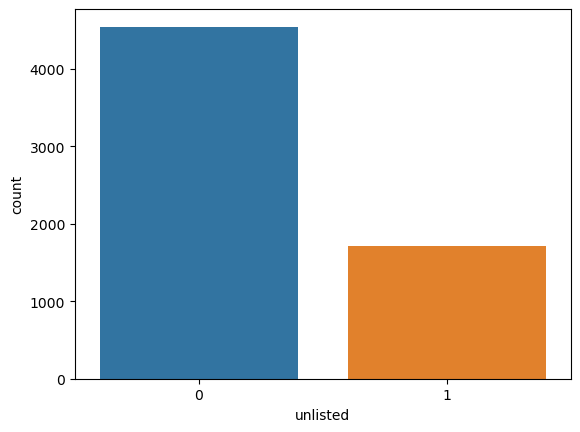

In [12]:
sns.countplot(x='unlisted', data=df_train)
plt.show()


In [13]:
df_train['comment_count'] = df_train.filter(like='comment').count(axis=1)

#average
print(df_train.groupby('unlisted')['comment_count'].mean())

#median
print(df_train.groupby('unlisted')['comment_count'].median())


unlisted
0    76.188767
1     9.007026
Name: comment_count, dtype: float64
unlisted
0    38.0
1     0.0
Name: comment_count, dtype: float64


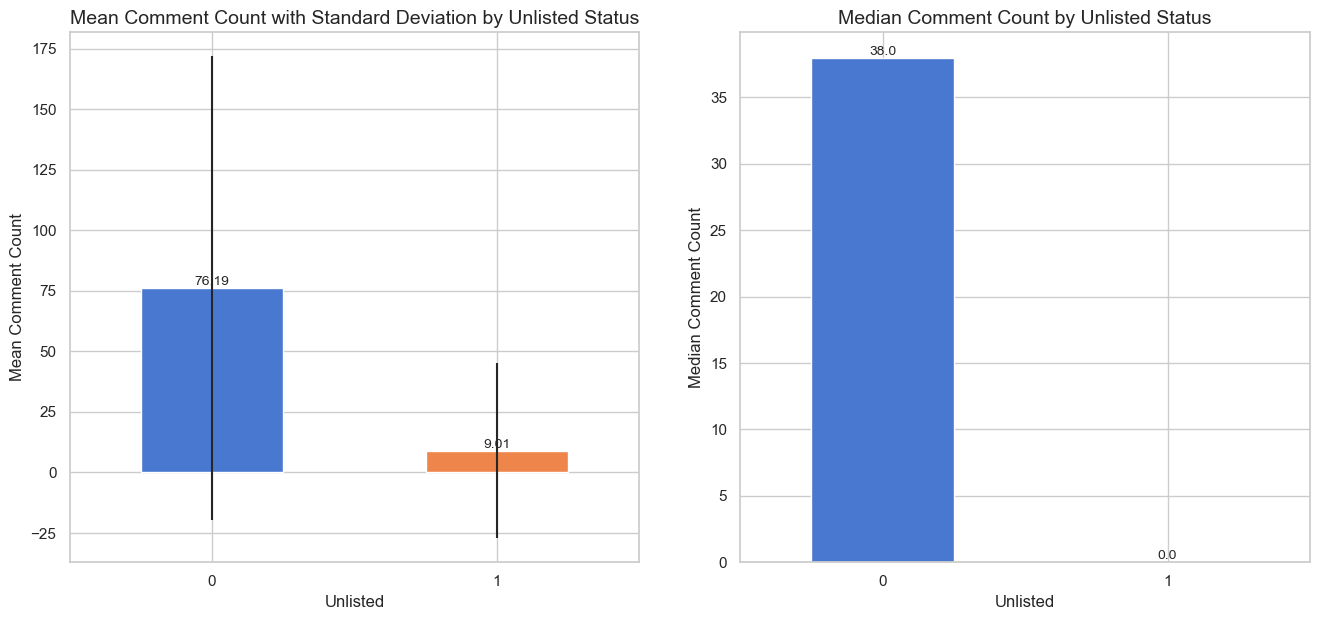

In [14]:
sns.set(style="whitegrid")

std_dev = df_train.groupby('unlisted')['comment_count'].std()

median_comment_count = df_train.groupby('unlisted')['comment_count'].median()

mean_comment_count = df_train.groupby('unlisted')['comment_count'].mean()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

mean_comment_count.plot(kind='bar', yerr=std_dev, ax=axes[0], color=sns.color_palette("muted"))
axes[0].set_xlabel('Unlisted', fontsize=12)
axes[0].set_ylabel('Mean Comment Count', fontsize=12)
axes[0].set_title('Mean Comment Count with Standard Deviation by Unlisted Status', fontsize=14)
axes[0].tick_params(axis='x', rotation=0)
axes[0].tick_params(axis='y', rotation=0)

for index, value in enumerate(mean_comment_count):
    axes[0].text(index, value, round(value, 2), ha='center', va='bottom', fontsize=10)

median_comment_count.plot(kind='bar', ax=axes[1], color=sns.color_palette("muted"))
axes[1].set_xlabel('Unlisted', fontsize=12)
axes[1].set_ylabel('Median Comment Count', fontsize=12)
axes[1].set_title('Median Comment Count by Unlisted Status', fontsize=14)
axes[1].tick_params(axis='x', rotation=0)
axes[1].tick_params(axis='y', rotation=0)

for index, value in enumerate(median_comment_count):
    axes[1].text(index, value, round(value, 2), ha='center', va='bottom', fontsize=10)

plt.tight_layout(pad=3.0)

plt.show()




In [15]:
# lets create a df valled df_train_reviews_10 that contains the first 14 columns
df_train = df_train.iloc[:, :15]

df_train

,index,description,host_about,unlisted,comment 0,comment 1,comment 2,comment 3,comment 4,comment 5,comment 6,comment 7,comment 8,comment 9,comment 10
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,this is a very cozy and comfortable house to s...,good<br/>,"My first hostel experience, and all I have to ...",Das Hostel war neu und deshalb funktionierte a...,"It was fine for a dorm, but I think for the pe...",Our stay in Lisbon Tip Hostel was very good. T...,Close to shops in town and a comfortable place...,Young and friendly staff. Great location along...,The place is just off the Parque metro stop wh...,Had a nice stay at this hostel. The beds were ...,Well located and clean.
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0,Un très bel appartement avec une magnifique vu...,"Appartement refait à neuf, très confortable et...","Apartamento limpio, amplio y con unas vistas i...",Apartamento remodelado com tudo o que é necess...,Mein Freund und ich waren Im August eine Woche...,"Netter Empfang. Toller Ausblick, da im 8. Stoc...",We really enjoyed staying at Sonias place. The...,Groot appartement op een zeer centrale locatie...,Lovely apartment with great views of the beach...,"Excelent location, superb view of the beach.",Nice apartment very close to the beach and wit...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6243,6244,"Studio 15 is a new, very well decorated and co...",I'm a Brand Manager from Lisbon in Portugal bu...,0,"Ottimo host, gentile, veloce e simpatico.<br/>...",Nous avons passé d’excellentes vacances à Lisb...,Rien à redire sur l’équipement et la propreté ...,Excelente apartamento y muy céntrico. Se puede...,Vasco was a wonderful host. He went out o his ...,"Un endroit bien situé, propre, complet et conf...",Vasco was a fantastic host and the apartment w...,Thank you so much we love it so much,"Beautiful, sparkling clean apartment with all ...","When we just arrived at the airport, we‘ve bee...",Vasco and Anna were amazing hosts! They picke...
6244,6245,Lisbon meets a cosmopolitan industrial one-bed...,Home is where feelings are visitors. How do we...,0,Newly & nicely refurbished apartment (May 2016...,Nuestra valoración de la estancia en este aloj...,"Great service, nice & new appartment and a per...",Nous avons été très bien accueillis avec une p...,We wanted to have a prime location in Bairro A...,Séjour très agréable et emplacement idéal en p...,Séjour très agréable avec un accueil sympathiq...,Superbe appartement correspondant parfaitement...,We had a warm welcome on arrival from Maria wh...,"Great time, great advice and warm welcoming! M...",We loved the stay in this lovely small apartme...
6245,6246,<b>License number</b><br />Exempt,I am a travel agent passionate by cultures. \n...,1,Do not recommend. <br/><br/>Host extremely har...,Sara's place is as described and even though i...,Fantastic location and smooth check in. Thanks...,"The apartment is okay, although a bit cold whi...",Que dire si ce n’est que Sara est une personne...,Sara es una anfitriona genial. Siempre estuvo ...,"En general todo muy bien, la ubicación es muy ...",Logement idéalement situé si vous souhaitez vi...,"Location, location, location!! If beach vibes,...",Buena ubicación y Sara muy atenta en todo mome...,Sara una afitriona muy buena. La casa por lo g...
6246,6247,Campo Pequeno Prestige is a classy and top qua...,Família_x000D_\nPortugal_x000D_\nGavião_x000D_...,0,

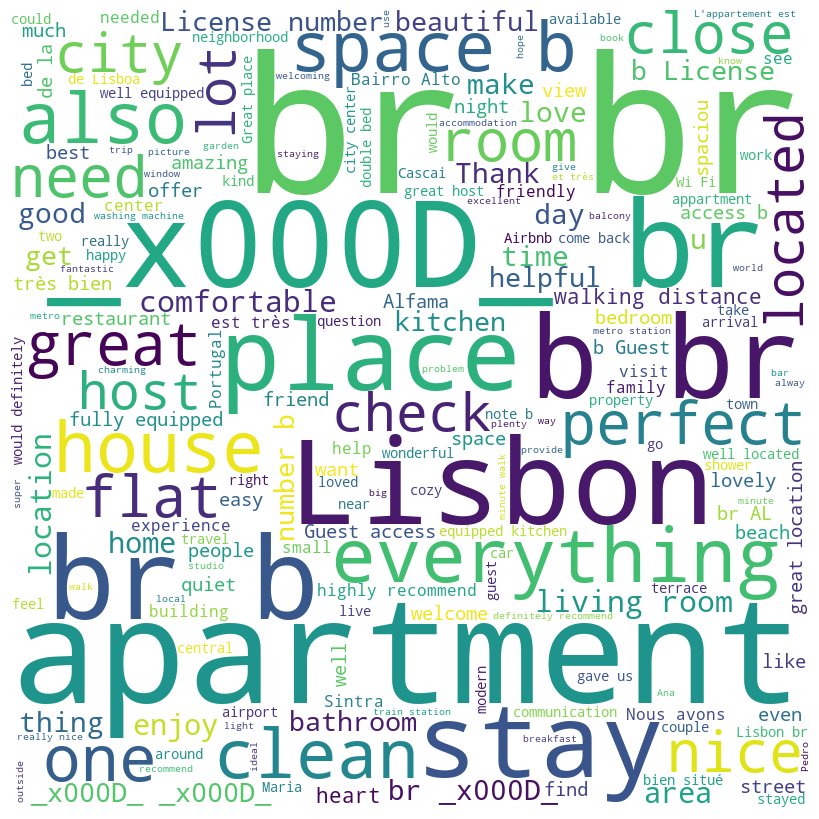

In [16]:
def create_wordcloud(text):
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = set(stopwords.words('english')), 
                min_font_size = 10).generate(text)
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()

text = ' '.join(df_train['description'].fillna('') + ' ' + df_train['host_about'].fillna('') + ' ' + df_train['comment 1'].fillna('') + ' ' + df_train['comment 2'].fillna('') + ' ' + df_train['comment 3'].fillna('') + ' ' + df_train['comment 4'].fillna('') + ' ' + df_train['comment 5'].fillna('') + ' ' + df_train['comment 6'].fillna('') + ' ' + df_train['comment 7'].fillna('') + ' ' + df_train['comment 8'].fillna('') + ' ' + df_train['comment 9'].fillna('') + ' ' + df_train['comment 10'].fillna(''))

create_wordcloud(text)



In [20]:
def clean_text(text):
    if isinstance(text, int):
        text = str(text)
    
    text = re.sub(r'_?x0{1,10}d_?', '', text, flags=re.IGNORECASE)
    
    if '<' in text:
        clean_text = BeautifulSoup(text, "html.parser").get_text()
    else:
        clean_text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    
    return clean_text

def clean_dataframe(df):
    for col in df.columns:
        if col != 'index':
            df[col] = df[col].apply(lambda x: clean_text(str(x)) if pd.notnull(x) else x)
    return df

df_train = clean_dataframe(df_train)


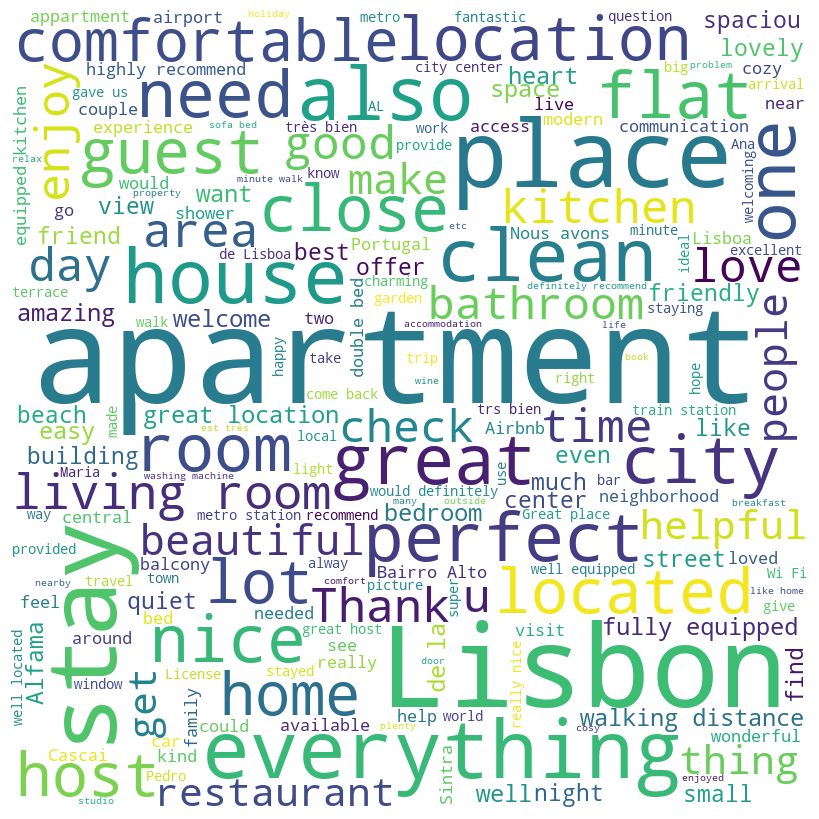

In [18]:
text = ' '.join(df_train['description'].fillna('') + ' ' + df_train['host_about'].fillna('') + ' ' + df_train['comment 1'].fillna('') + ' ' + df_train['comment 2'].fillna('') + ' ' + df_train['comment 3'].fillna('') + ' ' + df_train['comment 4'].fillna('') + ' ' + df_train['comment 5'].fillna('') + ' ' + df_train['comment 6'].fillna('') + ' ' + df_train['comment 7'].fillna('') + ' ' + df_train['comment 8'].fillna('') + ' ' + df_train['comment 9'].fillna('') + ' ' + df_train['comment 10'].fillna(''))

create_wordcloud(text)

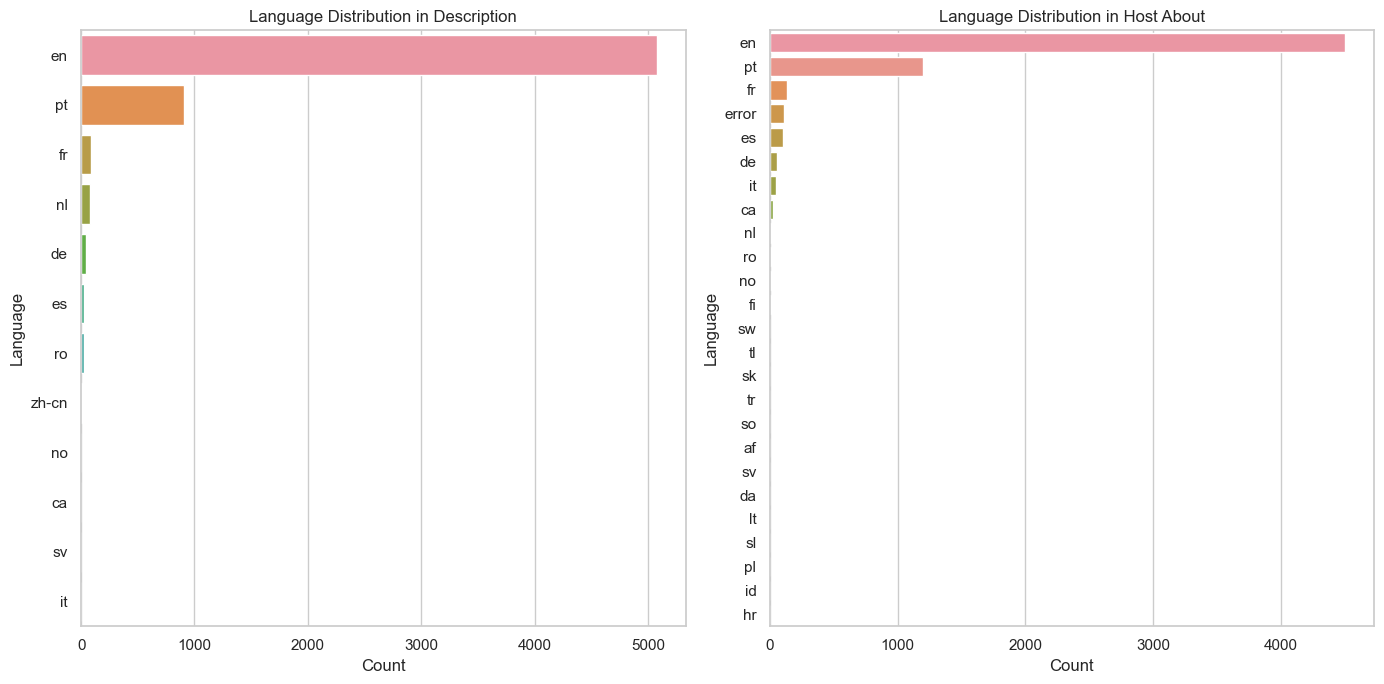

In [19]:
DetectorFactory.seed = 0

def detect_language(text):
    try:
        return detect(text)
    except:
        return 'error'

df_train['lang_description'] = df_train['description'].apply(detect_language)
df_train['lang_host_about'] = df_train['host_about'].apply(detect_language)

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
sns.countplot(y='lang_description', data=df_train, order = df_train['lang_description'].value_counts().index)
plt.title('Language Distribution in Description')
plt.xlabel('Count')
plt.ylabel('Language')

plt.subplot(1, 2, 2)
sns.countplot(y='lang_host_about', data=df_train, order = df_train['lang_host_about'].value_counts().index)
plt.title('Language Distribution in Host About')
plt.xlabel('Count')
plt.ylabel('Language')

plt.tight_layout()
plt.show()

In [20]:
# checking for rows where language of description and host_about don't match
mismatch_mask = df_train['lang_description'] != df_train['lang_host_about']
percentage_mismatch = (mismatch_mask.sum() / len(df_train)) * 100
percentage_mismatch

23.67157490396927

In [29]:
#make a copy of the dataframe
df_train_copy = df_train.copy()


# 3 - EMBEDDINGS

## 3.1 - NO TRANSLATION - USING TRANSFORMERS   

### 3.1.1 - MULTI LANGUAGE DISTILBERT

In [250]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')
model = DistilBertModel.from_pretrained('distilbert-base-multilingual-cased')

def get_distilbert_embedding(text):
    if not text.strip():
        return np.zeros(model.config.hidden_size)
    
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    embeddings = torch.mean(outputs.last_hidden_state, dim=1).squeeze(0)
    return embeddings.numpy()

In [ ]:

descriptions = df_train['description'].astype(str).tolist()
description_embeddings = []

for desc in tqdm(descriptions, desc="Embedding descriptions"):
    description_embeddings.append(get_distilbert_embedding(desc))

df_train['description_embedding'] = description_embeddings


Embedding descriptions:   0%|          | 0/6248 [00:00<?, ?it/s]

In [ ]:
host_abouts = df_train['host_about'].astype(str).tolist()

host_about_embeddings = []
for host_about in tqdm(host_abouts, desc="Embedding host abouts"):
    host_about_embeddings.append(get_distilbert_embedding(host_about))

df_train['host_about_embedding'] = host_about_embeddings



Embedding host abouts:   0%|          | 0/6248 [00:00<?, ?it/s]

In [ ]:
print(df_train.head())
for i in range(5):
    print(f"Embedding length for row {i+1}: {len(df_train['host_about_embedding'][i])}")


   index                                        description  \
0      1  This is a shared mixed room in our hostel, wit...   
1      2  O meu espao fica perto de Parque Eduardo VII S...   
2      3  Trafaria’s House is a cozy and familiar villa ...   
3      4  Apartamento Charmoso no Chiado, Entre o Largo ...   
4      5  Joli appartement  en bordure de mer. 2 min. a ...   

                                          host_about unlisted  \
0                  Alojamento Local Registro 20835AL        0   
1  I am friendly host and I will try to always be...        1   
2  I am a social person liking to communicate rea...        1   
3  Hello\nI m Portuguese and i love to meet peopl...        0   
4  Nous sommes une famille avec deux enfants de 1...        0   

                                           comment 1  \
0                                          Very Nice   
1                                                      
2                                                      
3     

In [ ]:
comments_columns = ['comment 1', 'comment 2', 'comment 3', 'comment 4', 'comment 5', 
                    'comment 6', 'comment 7', 'comment 8', 'comment 9', 'comment 10']

comments_embeddings = {col: [] for col in comments_columns}

In [ ]:

for col in comments_columns:
    comments = df_train[col].tolist()
    for comment in tqdm(comments, desc=f"Embedding {col}"):
        if isinstance(comment, str):
            comments_embeddings[col].append(get_distilbert_embedding(comment))
        else:
            comments_embeddings[col].append(np.zeros(768))

for col in comments_columns:
    df_train[f'{col}_embedding'] = comments_embeddings[col]

Embedding comment 1:   0%|          | 0/6248 [00:00<?, ?it/s]

Embedding comment 2:   0%|          | 0/6248 [00:00<?, ?it/s]

Embedding comment 3:   0%|          | 0/6248 [00:00<?, ?it/s]

Embedding comment 4:   0%|          | 0/6248 [00:00<?, ?it/s]

Embedding comment 5:   0%|          | 0/6248 [00:00<?, ?it/s]

Embedding comment 6:   0%|          | 0/6248 [00:00<?, ?it/s]

Embedding comment 7:   0%|          | 0/6248 [00:00<?, ?it/s]

Embedding comment 8:   0%|          | 0/6248 [00:00<?, ?it/s]

Embedding comment 9:   0%|          | 0/6248 [00:00<?, ?it/s]

Embedding comment 10:   0%|          | 0/6248 [00:00<?, ?it/s]

In [ ]:
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=42)


In [ ]:

X_train = df_train[['description_embedding', 'host_about_embedding', 
                    'comment 1_embedding', 'comment 2_embedding', 'comment 3_embedding', 
                    'comment 4_embedding', 'comment 5_embedding', 'comment 6_embedding', 
                    'comment 7_embedding', 'comment 8_embedding', 'comment 9_embedding', 
                    'comment 10_embedding']]
X_val = df_val[['description_embedding', 'host_about_embedding',
                'comment 1_embedding', 'comment 2_embedding', 'comment 3_embedding', 
                'comment 4_embedding', 'comment 5_embedding', 'comment 6_embedding', 
                'comment 7_embedding', 'comment 8_embedding', 'comment 9_embedding', 
                'comment 10_embedding']]

y_train = df_train['unlisted']
y_val = df_val['unlisted']




In [ ]:
X_train.shape

(4998, 12)

In [ ]:
X_train['description_embedding'][0]

array([-2.68795937e-01, -2.42961258e-01,  1.72223225e-01, -2.78670229e-02,
        1.77748695e-01,  1.28156334e-01, -2.34691724e-01,  1.01733364e-01,
       -1.69502065e-01, -5.24796396e-02, -4.62848097e-02,  4.21772808e-01,
        5.54397225e-01,  3.29672694e-01,  2.12543219e-01, -3.75845313e-01,
        6.02850616e-01, -3.91549528e-01,  1.75538480e-01,  2.63767600e-01,
        1.02814466e-01,  1.52038634e-01,  3.83802891e-01, -7.42764547e-02,
        2.30796829e-01,  1.22862227e-01, -4.47881520e-01,  1.07356779e-01,
       -1.30138290e-03, -3.27058673e-01, -9.76725761e-03,  3.79417866e-01,
       -2.71274328e-01,  6.91155136e-01,  9.84018221e-02,  1.15083940e-01,
        1.32930085e-01,  2.18039423e-01,  6.89429268e-02, -8.00538510e-02,
        3.23169120e-02,  3.13750327e-01,  1.54451311e-01, -1.47131458e-01,
        2.19669834e-01, -1.26124278e-01,  2.93045640e-01,  8.36583599e-02,
       -1.22524738e-01, -1.22910269e-01, -3.52129936e-02, -2.42148623e-01,
        3.85308832e-01,  

In [ ]:
y_train

1738    0
142     1
2638    0
3407    1
5650    0
       ..
3772    0
5191    1
5226    0
5390    0
860     1
Name: unlisted, Length: 4998, dtype: object

In [ ]:
X_train.head()

,description_embedding,host_about_embedding,comment 1_embedding,comment 2_embedding,comment 3_embedding,comment 4_embedding,comment 5_embedding,comment 6_embedding,comment 7_embedding,comment 8_embedding,comment 9_embedding,comment 10_embedding
1738,"[-0.23530668, -0.33839998, 0.33047462, 0.07122...","[-0.04256296, -0.15366057, -0.120283484, 0.395...","[0.09037343, -0.20292337, 0.1431247, 0.1589535...","[-0.1787788, -0.35959342, -0.04760647, 0.02264...","[0.040639155, -0.29456124, 0.28896725, 0.42972...","[-0.090141065, -0.53219813, 0.3240194, 0.46815...","[0.104196586, -0.18798164, 0.44960222, 0.31420...","[-0.18548732, -0.3183362, -0.295636, 0.2092443...","[0.03437853, -0.18645819, -0.0070517757, 0.212...","[-0.27099264, -0.523219, 0.29767436, 0.0444691...","[0.003647952, -0.32476208, 0.5379392, 0.313290...","[-0.16650839, -0.28550646, 0.36706597, 0.14799..."
142,"[0.055727407, -0.16742255, 0.35076088, 0.33966...","[-0.22538137, -0.40542316, -0.07076159, -0.146...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2638,"[-0.33400124, -0.21492405, 0.18315586, -0.0392...","[-0.22883394, -0.0008261181, 0.10724445, -0.05...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3407,"[-0.39565483, -0.30279475, 0.20511808, -0.1217...","[0.2201043, -0.11754492, 0.25464883, 0.1068565...","[-0.104928866, -0.5147655, 0.11046683, 0.02960...","[0.045188297, -0.37775227, -0.3434282, 0.41255...","[-0.17907572, -0.44759983, 0.2629546, -0.04663...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5650,"[-0.6037424, -0.30190673, 0.14401147, -0.11429...","[0.1488951, -0.07589937, 0.35994726, 0.1156875...","[-0.12555537, -0.16222171, -0.075729534, 0.051...","[0.1788513, -0.08927859, 0.0065753856, 0.14931...","[-0.09067381, -0.29987076, 0.23632985, 0.07649...","[-0.17060867, -0.2393199, 0.004098403, 0.16565...","[-0.029564092, -0.087317124, 0.055836074, 0.06...","[-0.013055558, -0.23184152, -0.08078986, 0.065...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:

X_train.to_pickle("/Users/diogoparreira/Downloads/Project Corpora/train_embeddings_BERT.pkl")
X_val.to_pickle("/Users/diogoparreira/Downloads/Project Corpora/X_val_embeddings_BERT.pkl")


In [ ]:
df_train = pd.read_pickle("/Users/diogoparreira/Downloads/Project Corpora/train_embeddings_BERT.pkl")
df_val = pd.read_pickle("/Users/diogoparreira/Downloads/Project Corpora/X_val_embeddings_BERT.pkl")

df_combined = pd.concat([df_train, df_val], ignore_index=False)

# Sort the dataframe by its index to restore the original order
df_combined.sort_index(inplace=True)
df_train=df_combined

df_train

,description_embedding,host_about_embedding,comment 1_embedding,comment 2_embedding,comment 3_embedding,comment 4_embedding,comment 5_embedding,comment 6_embedding,comment 7_embedding,comment 8_embedding,comment 9_embedding,comment 10_embedding
0,"[-0.26879594, -0.24296126, 0.17222323, -0.0278...","[-0.023185158, -0.37697086, 0.6086536, -0.1410...","[0.21510991, -0.5110688, 0.69160336, 0.2025546...","[0.18484162, -0.56833196, 0.47783622, 0.284128...","[0.09349856, -0.63477594, -0.14457683, 0.41328...","[-0.29734465, -0.19852522, 0.17212053, 0.20468...","[-0.20384422, -0.30479306, 0.32439762, 0.36521...","[-0.0023590056, -0.10258668, -0.15480903, 0.17...","[0.1438322, -0.0015778223, 0.27991143, 0.13235...","[-0.023849774, -0.20133433, 0.050635666, 0.209...","[-0.2545836, -0.2023835, 0.70131767, -0.157883...","[-0.30182463, -0.3476164, -0.053347576, -0.045..."
1,"[0.18437931, -0.11173112, 0.43281272, 0.089186...","[-0.15800077, -0.33181137, -0.24007031, 0.0658...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-0.213159, -0.13738346, 0.23962368, -0.084870...","[-0.03918232, -0.2257988, 0.08007751, 0.135921...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[0.23830405, -0.05339681, 0.59072655, 0.043042...","[0.0016663807, -0.23362859, 0.20633163, 0.0659...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.2337263, -0.20460261, 0.038895655, 0.12549...","[-0.16636522, -0.16522944, -0.0675881, 0.05344...","[-0.025955671, -0.082295895, 0.46097443, 0.105...","[-0.122491114, -0.21452355, 0.2420692, 0.22980...","[-0.12166471, -0.15910466, -0.09568889, 0.0760...","[-0.17308037, -0.19063288, 0.24026674, 0.48821...","[-0.0561226, -0.3945254, 0.045986615, 0.186733...","[-0.26298475, -0.1668021, 0.085691415, 0.17763...","[-0.25435126, -0.457975, -0.060825888, 0.20592...","[-0.32600078, -0.12007493, 0.06251769, 0.07930...","[0.21353221, -0.4629201, -0.20554884, 0.019670...","[-0.040487032, -0.22121687, 0.09313486, -0.129..."
...,...,...,...,...,...,...,...,...,...,...,...,...
6243,"[-0.23381792, -0.3406445, 0.2648894, -0.109164...","[0.016132843, -0.32295823, -0.038150858, -0.01...","[-0.015997717, -0.36677986, -0.14587337, 0.163...","[-0.24943158, -0.3896658, -0.05980366, -0.1709...","[0.029333342, -0.1336594, -0.19647847, 0.05486...","[-0.17590089, -0.2549514, -0.16108687, 0.05244...","[-0.022897553, -0.47838372, 0.24754673, -0.006...","[-0.018899033, -0.04430035, -0.0009475003, 0.2...","[-0.2557296, -0.4468652, -0.1942629, 0.0926911...","[0.012373454, -0.29184496, -0.13969262, -0.030...","[-0.12030066, -0.21061252, -0.16211589, -0.051.

In [ ]:
y = pd.read_excel("/Users/diogoparreira/Downloads/Project Corpora/train.xlsx")
y_train = y['unlisted']

In [ ]:
def flatten_row(row):
    return np.concatenate(row.values)

df_train_flattened = df_train.apply(flatten_row, axis=1)

X_train = np.vstack(df_train_flattened.values)

X_train = np.array(X_train)

y_train = np.array(y_train)

y_train = y_train.astype(np.float32)



In [ ]:

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_train type:", type(X_train))
print("y_train type:", type(y_train))


X_train shape: (6248, 9216)
y_train shape: (6248,)
X_train type: <class 'numpy.ndarray'>
y_train type: <class 'numpy.ndarray'>


In [63]:
def rfe_test(X_train, y_train, num_folds=5, random_state=42):
    rf = RandomForestClassifier(random_state=random_state)
    
    scoring = ['accuracy', 'recall', 'precision', 'f1']
    
    cv_results = cross_validate(rf, X_train, y_train, cv=num_folds, scoring=scoring, return_train_score=False)
    
    mean_scores = {metric: np.mean(cv_results[f'test_{metric}']) for metric in scoring}
    std_scores = {metric: np.std(cv_results[f'test_{metric}']) for metric in scoring}
    
    print('Average scores for all folds:')
    for metric in scoring:
        print(f'> {metric.capitalize()}: {mean_scores[metric]:.4f} (+- {std_scores[metric]:.4f})')

    return cv_results




In [ ]:
rfe_results_BERT_FULL = rfe_test(X_train, y_train)


Average scores for all folds:
> Accuracy: 0.8916 (+- 0.0060)
> Recall: 0.8273 (+- 0.0187)
> Precision: 0.7873 (+- 0.0109)
> F1: 0.8067 (+- 0.0113)


In [64]:
def knn_test(X_train, y_train, num_folds=5, n_neighbors=10, random_state=42):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)

    scoring = ['accuracy', 'recall', 'precision', 'f1']
    
    cv_results = cross_validate(knn, X_train, y_train, cv=num_folds, scoring=scoring, return_train_score=False)

    accuracy_per_fold = cv_results['test_accuracy'].tolist()
    recall_per_fold = cv_results['test_recall'].tolist()
    precision_per_fold = cv_results['test_precision'].tolist()
    f1_score_per_fold = cv_results['test_f1'].tolist()

    print('Average scores for all folds:')
    print(f'> Accuracy: {np.mean(accuracy_per_fold)} (+- {np.std(accuracy_per_fold)})')
    print(f'> Recall: {np.mean(recall_per_fold)}')
    print(f'> Precision: {np.mean(precision_per_fold)}')
    print(f'> F1-score: {np.mean(f1_score_per_fold)}')

    return accuracy_per_fold, recall_per_fold, precision_per_fold, f1_score_per_fold





In [ ]:
knn_results_BERT_FULL = knn_test(X_train, y_train)

/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Average scores for all folds:
> Accuracy: 0.8724400320256205 (+- 0.008862580532297179)
> Recall: 0.7710792131844764
> Precision: 0.7649343319386728
> F1-score: 0.7677618784143067


In [65]:
def nn_test(X_train, y_train, num_folds=5, nn_epochs=20, nn_batch_size=32, random_state=42):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=random_state)

    accuracy_per_fold = []
    loss_per_fold = []
    recall_per_fold = []
    precision_per_fold = []
    f1_score_per_fold = []

    fold_no = 1
    for train_index, val_index in kf.split(X_train):
        print(f'Training fold {fold_no} for NN...')

        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        model = Sequential([
            Dense(64, activation='relu', input_shape=(X_train_fold.shape[1],)),
            Dropout(0.2),
            Dense(32, activation='relu'),
            Dropout(0.2),
            Dense(1, activation='sigmoid')
        ])

        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        model_checkpoint = ModelCheckpoint(f'model_fold_{fold_no}.keras', save_best_only=True, monitor='val_loss')

        history = model.fit(X_train_fold, y_train_fold, 
                            validation_data=(X_val_fold, y_val_fold), 
                            epochs=nn_epochs, 
                            batch_size=nn_batch_size, 
                            callbacks=[early_stopping, model_checkpoint], 
                            verbose=1)

        y_pred = model.predict(X_val_fold)
        y_pred_classes = (y_pred > 0.5).astype(int)

        report = classification_report(y_val_fold, y_pred_classes, target_names=['Class 0', 'Class 1'], output_dict=True)

        recall_per_fold.append(report['Class 1']['recall'])
        precision_per_fold.append(report['Class 1']['precision'])
        f1_score_per_fold.append(report['Class 1']['f1-score'])

        scores = model.evaluate(X_val_fold, y_val_fold, verbose=0)
        accuracy_per_fold.append(scores[1])
        loss_per_fold.append(scores[0])

        fold_no += 1

    print('Average scores for NN:')
    print(f'> Accuracy: {np.mean(accuracy_per_fold)} (+- {np.std(accuracy_per_fold)})')
    print(f'> Loss: {np.mean(loss_per_fold)}')
    print(f'> Recall: {np.mean(recall_per_fold)}')
    print(f'> Precision: {np.mean(precision_per_fold)}')
    print(f'> F1-score: {np.mean(f1_score_per_fold)}')

    return accuracy_per_fold, loss_per_fold, recall_per_fold, precision_per_fold, f1_score_per_fold

In [ ]:
nn_results_BERT_FULL = nn_test(X_train, y_train)


Training fold 1 for NN...


/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8155 - loss: 0.4343 - val_accuracy: 0.8704 - val_loss: 0.3366
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8655 - loss: 0.3712 - val_accuracy: 0.8688 - val_loss: 0.3751
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8681 - loss: 0.3634 - val_accuracy: 0.8776 - val_loss: 0.3380
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8621 - loss: 0.3495 - val_accuracy: 0.8736 - val_loss: 0.3483
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Training fold 2 for NN...


/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8366 - loss: 0.4087 - val_accuracy: 0.8728 - val_loss: 0.3437
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8622 - loss: 0.3688 - val_accuracy: 0.8776 - val_loss: 0.3367
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8659 - loss: 0.3514 - val_accuracy: 0.8784 - val_loss: 0.3380
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8815 - loss: 0.3190 - val_accuracy: 0.8776 - val_loss: 0.3324
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8805 - loss: 0.3261 - val_accuracy: 0.8760 - val_loss: 0.3324
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8768 - loss: 0.3041 - val_accuracy: 0.8768 - val_loss: 0.3338
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8715 - loss: 0.3110 - val_accuracy: 0.8832 - val_loss: 0.3425
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8870 - loss: 0.2771 - val_accuracy: 0.

/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8165 - loss: 0.4233 - val_accuracy: 0.8544 - val_loss: 0.3635
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8720 - loss: 0.3397 - val_accuracy: 0.8616 - val_loss: 0.3818
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8748 - loss: 0.3414 - val_accuracy: 0.8632 - val_loss: 0.3586
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8742 - loss: 0.3236 - val_accuracy: 0.8664 - val_loss: 0.3598
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8821 - loss: 0.3067 - val_accuracy: 0.8664 - val_loss: 0.3569
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8774 - loss: 0.2943 - val_accuracy: 0.8696 - val_loss: 0.3561
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8742 - loss: 0.2908 - val_accuracy: 0.8680 - val_loss: 0.3632
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8783 - loss: 0.2888 - val_accuracy: 0.

/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8391 - loss: 0.4033 - val_accuracy: 0.8711 - val_loss: 0.3383
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8617 - loss: 0.3529 - val_accuracy: 0.8727 - val_loss: 0.3373
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8756 - loss: 0.3405 - val_accuracy: 0.8855 - val_loss: 0.3364
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8809 - loss: 0.3307 - val_accuracy: 0.8823 - val_loss: 0.3264
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8799 - loss: 0.3176 - val_accuracy: 0.8823 - val_loss: 0.3335
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8766 - loss: 0.3073 - val_accuracy: 0.8839 - val_loss: 0.3329
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8802 - loss: 0.2932 - val_accuracy: 0.8719 - val_loss: 0.3444
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Training fold 5 for NN...


/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8232 - loss: 0.4130 - val_accuracy: 0.8695 - val_loss: 0.3505
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8680 - loss: 0.3664 - val_accuracy: 0.8751 - val_loss: 0.3424
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8690 - loss: 0.3513 - val_accuracy: 0.8767 - val_loss: 0.3365
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8767 - loss: 0.3371 - val_accuracy: 0.8799 - val_loss: 0.3385
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8822 - loss: 0.3123 - val_accuracy: 0.8743 - val_loss: 0.3410
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8814 - loss: 0.3065 - val_accuracy: 0.8767 - val_loss: 0.3442
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Average scores for NN:
> Accuracy: 0.8750014424324035 (+- 0.004638751685808939)
> Loss: 0.3376060962677002
> Recall: 0.8348250896833992
> Precision: 0.7411015923792525
> F1-score: 0.78489828248

In [34]:
# Do we need all the 10 comments or can we just average them?

In [ ]:
def average_and_reduce(row, num_features=12, embedding_size=768, num_comments=10):

    embeddings = row.reshape((num_features, embedding_size))

    averaged_comments = np.mean(embeddings[-num_comments:], axis=0)

    reduced_embeddings = np.concatenate([embeddings[0], embeddings[1], averaged_comments])
    return reduced_embeddings

X_train = np.apply_along_axis(average_and_reduce, 1, X_train)

# Verify the shapes
print("X_train_reduced shape:", X_train.shape) 



In [ ]:
rfe_results_BERT_AVG = rfe_test(X_train, y_train)

Average scores for all folds:
> Accuracy: 0.8920 (+- 0.0056)
> Recall: 0.8308 (+- 0.0177)
> Precision: 0.7862 (+- 0.0084)
> F1: 0.8078 (+- 0.0107)


In [ ]:
knn_results_BERT_AVG = knn_test(X_train, y_train)


Average scores for all folds:
> Accuracy: 0.854994907926341 (+- 0.009024150546965587)
> Recall: 0.7482533312754027
> Precision: 0.7286241621217098
> F1-score: 0.7382321595171029


In [ ]:
nn_results_BERT_AVG = nn_test(X_train, y_train)

Training fold 1 for NN...
Epoch 1/20


/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8119 - loss: 0.4159 - val_accuracy: 0.8520 - val_loss: 0.3468
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8608 - loss: 0.3634 - val_accuracy: 0.8768 - val_loss: 0.3312
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8665 - loss: 0.3406 - val_accuracy: 0.8752 - val_loss: 0.3339
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8605 - loss: 0.3580 - val_accuracy: 0.8728 - val_loss: 0.3328
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8792 - loss: 0.3280 - val_accuracy: 0.8840 - val_loss: 0.3161
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8693 - loss: 0.3459 - val_accuracy: 0.8784 - val_loss: 0.3286
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8777 - loss: 0.3287 - val_accuracy: 0.8824 - val_loss: 0.3271
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8903 - loss: 0.3067 - val_accuracy: 0.8792 - val_

/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8032 - loss: 0.4340 - val_accuracy: 0.8392 - val_loss: 0.3756
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8440 - loss: 0.3744 - val_accuracy: 0.8696 - val_loss: 0.3425
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8624 - loss: 0.3527 - val_accuracy: 0.8672 - val_loss: 0.3417
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8690 - loss: 0.3420 - val_accuracy: 0.8760 - val_loss: 0.3327
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8831 - loss: 0.3251 - val_accuracy: 0.8704 - val_loss: 0.3303
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8838 - loss: 0.3339 - val_accuracy: 0.8768 - val_loss: 0.3254
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8817 - loss: 0.3230 - val_accuracy: 0.8816 - val_loss: 0.3259
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8762 - loss: 0.3130 - val_accuracy: 0.8768 - val_

/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7957 - loss: 0.4390 - val_accuracy: 0.8424 - val_loss: 0.3983
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8617 - loss: 0.3635 - val_accuracy: 0.8504 - val_loss: 0.3629
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8604 - loss: 0.3421 - val_accuracy: 0.8656 - val_loss: 0.3598
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8740 - loss: 0.3326 - val_accuracy: 0.8640 - val_loss: 0.3478
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8737 - loss: 0.3353 - val_accuracy: 0.8656 - val_loss: 0.3505
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8730 - loss: 0.3368 - val_accuracy: 0.8728 - val_loss: 0.3383
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8856 - loss: 0.3178 - val_accuracy: 0.8728 - val_loss: 0.3374
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8872 - loss: 0.3171 - val_accuracy: 0.8712 - val_

/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7760 - loss: 0.4633 - val_accuracy: 0.8615 - val_loss: 0.3496
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8503 - loss: 0.3786 - val_accuracy: 0.8727 - val_loss: 0.3438
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8678 - loss: 0.3406 - val_accuracy: 0.8711 - val_loss: 0.3426
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8675 - loss: 0.3403 - val_accuracy: 0.8775 - val_loss: 0.3487
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8640 - loss: 0.3574 - val_accuracy: 0.8775 - val_loss: 0.3469
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8640 - loss: 0.3359 - val_accuracy: 0.8767 - val_loss: 0.3462
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Training fold 5 for NN...
Epoch 1/20


/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8065 - loss: 0.4172 - val_accuracy: 0.8551 - val_loss: 0.3499
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8564 - loss: 0.3660 - val_accuracy: 0.8591 - val_loss: 0.3532
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8693 - loss: 0.3581 - val_accuracy: 0.8591 - val_loss: 0.3611
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8589 - loss: 0.3573 - val_accuracy: 0.8623 - val_loss: 0.3517
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Average scores for NN:
> Accuracy: 0.871956181526184 (+- 0.009535566332849932)
> Loss: 0.33428866863250734
> Recall: 0.8383408503488567
> Precision: 0.733410044480985
> F1-score: 0.7817682574664573


### 3.1.2 - USE

In [50]:
df_train = df_train_copy.copy()

In [51]:
import tensorflow as tf
import tensorflow_hub as hub

def download_and_load_use_model(module_url):
    try:
        model = hub.load(module_url)

        saved_model_path = "./use"
        tf.saved_model.save(model, saved_model_path)

        loaded_model = tf.saved_model.load(saved_model_path)

        return loaded_model

    except Exception as e:
        print("Error:", e)
        return None

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"

model = download_and_load_use_model(module_url)



INFO:tensorflow:Assets written to: ./use/assets


INFO:tensorflow:Assets written to: ./use/assets


Universal Sentence Encoder model downloaded, saved, and loaded successfully.


In [55]:

model_path = "./use"
embed = hub.load(model_path)

def get_use_embedding_USE(text):
    if pd.isna(text) or not text.strip():
        return np.zeros(512)  
    
    embeddings = embed([text])
    return embeddings.numpy()[0]  

num_rows = len(df_train)
num_columns = len(df_train.columns)
embeddings_dict = {col: [] for col in df_train.columns if col not in ['unlisted', 'index']}

for i in range(num_rows):
    row = df_train.iloc[i]
    for col in df_train.columns:
        if col not in ['unlisted', 'index']:
            cell_text = str(row[col]) if not pd.isna(row[col]) else "" 
            cell_embedding = get_use_embedding_USE(cell_text)
            embeddings_dict[col].append(cell_embedding)

for col in embeddings_dict.keys():
    df_train[col + '_embedding'] = embeddings_dict[col]




In [56]:
y_train = df_train['unlisted']
df_train = df_train[['description_embedding', 'host_about_embedding', 
                     'comment 1_embedding', 'comment 2_embedding', 'comment 3_embedding', 
                     'comment 4_embedding', 'comment 5_embedding', 'comment 6_embedding', 
                     'comment 7_embedding', 'comment 8_embedding', 'comment 9_embedding', 
                     'comment 10_embedding']]


In [57]:
df_train.head()

,description_embedding,host_about_embedding,comment 1_embedding,comment 2_embedding,comment 3_embedding,comment 4_embedding,comment 5_embedding,comment 6_embedding,comment 7_embedding,comment 8_embedding,comment 9_embedding,comment 10_embedding
0,"[0.0038962108, -0.067680076, 0.0044088494, 0.0...","[-0.030312773, 0.03881223, -0.034579214, -0.05...","[-0.044430234, -0.07187287, 0.015838875, -0.01...","[0.0023792242, -0.035928, -0.006911166, -0.031...","[-0.06271794, -0.032523487, -0.04933658, -0.02...","[-0.026332008, 0.05299235, -0.030287964, -0.05...","[-0.0092176, -0.04835325, -0.0073145945, -0.02...","[-0.07953057, 0.07491644, -0.007212198, 0.0614...","[-0.02567999, -0.0015543588, 0.025929691, -0.0...","[0.029461093, -0.031889137, -0.05380424, -0.01...","[-0.030950127, -0.0025467759, -0.040051363, -0...","[-0.07024333, 0.030079495, -0.018439475, -0.02..."
1,"[0.0130321365, 0.021076337, -0.028426776, 0.03...","[-0.0027194472, -0.04893354, 0.021487677, -0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-0.031612586, -0.054642692, 0.059779648, -0.0...","[0.023632426, -0.076990016, 0.06339732, -0.045...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[-0.0007519614, -4.7556077e-05, -0.056452848, ...","[0.007419858, -0.07843268, -0.035340853, -0.03...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.057713863, -0.06630155, -0.03148175, -0.05...","[-0.039623775, -0.063836806, 0.022248432, -0.0...","[-0.06466034, -0.02207149, -0.026388042, -0.04...","[-0.017600892, 0.0041359817, -0.06749367, 0.03...","[-0.019535093, 0.037963346, 0.04202935, 0.0117...","[-0.062209, -0.05075638, 0.036221024, 0.060014...","[0.027936518, -0.048197888, 0.002765247, 0.059...","[-0.0032475926, 0.0025658016, -0.033633873, -0...","[0.029385887, 0.013421444, -0.045710016, 0.033...","[-0.012294985, -0.06753084, 0.004338646, 0.002...","[-0.0024714195, 0.030031249, -0.05394092, -0.0...","[-0.016033651, -0.017371427, 0.021817744, -0.0..."


In [60]:
def flatten_row(row):
    return np.concatenate(row.values)

df_train_flattened = df_train.apply(flatten_row, axis=1)

In [61]:
X_train = np.vstack(df_train_flattened.values)

X_train = np.array(X_train)

y_train = np.array(y_train)

y_train = y_train.astype(np.float32)

In [62]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_train type:", type(X_train))
print("y_train type:", type(y_train))

X_train shape: (6248, 6144)
y_train shape: (6248,)
X_train type: <class 'numpy.ndarray'>
y_train type: <class 'numpy.ndarray'>


In [66]:
rfe_results_USE_FULL = rfe_test(X_train, y_train)

Average scores for all folds:
> Accuracy: 0.8809 (+- 0.0045)
> Recall: 0.8279 (+- 0.0149)
> Precision: 0.7586 (+- 0.0077)
> F1: 0.7917 (+- 0.0087)


In [67]:
knn_results_USE_FULL = knn_test(X_train, y_train)

python(37281) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Average scores for all folds:
> Accuracy: 0.4025278462770216 (+- 0.012072978813608306)
> Recall: 0.8846409768311296
> Precision: 0.29936213451076943
> F1-score: 0.4473393679497734


In [68]:
nn_results_USE_FULL = nn_test(X_train, y_train)

Training fold 1 for NN...


/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8002 - loss: 0.4283 - val_accuracy: 0.8664 - val_loss: 0.3400
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8711 - loss: 0.3289 - val_accuracy: 0.8728 - val_loss: 0.3344
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8754 - loss: 0.3008 - val_accuracy: 0.8664 - val_loss: 0.3670
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8946 - loss: 0.2496 - val_accuracy: 0.8736 - val_loss: 0.3632
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9007 - loss: 0.2284 - val_accuracy: 0.8664 - val_loss: 0.3914
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Training fold 2 for NN...


/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7884 - loss: 0.4196 - val_accuracy: 0.8688 - val_loss: 0.3466
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8661 - loss: 0.3411 - val_accuracy: 0.8712 - val_loss: 0.3389
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8728 - loss: 0.3128 - val_accuracy: 0.8736 - val_loss: 0.3441
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8818 - loss: 0.2686 - val_accuracy: 0.8480 - val_loss: 0.3723
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8983 - loss: 0.2464 - val_accuracy: 0.8600 - val_loss: 0.3859
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training fold 3 for NN...


/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7795 - loss: 0.4322 - val_accuracy: 0.8576 - val_loss: 0.3668
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8755 - loss: 0.3311 - val_accuracy: 0.8672 - val_loss: 0.3567
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8816 - loss: 0.2916 - val_accuracy: 0.8656 - val_loss: 0.3600
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8955 - loss: 0.2604 - val_accuracy: 0.8592 - val_loss: 0.3717
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9064 - loss: 0.2211 - val_accuracy: 0.8552 - val_loss: 0.3872
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Training fold 4 for NN...


/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7746 - loss: 0.4428 - val_accuracy: 0.8695 - val_loss: 0.3455
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8666 - loss: 0.3291 - val_accuracy: 0.8799 - val_loss: 0.3370
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8761 - loss: 0.3050 - val_accuracy: 0.8775 - val_loss: 0.3449
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8847 - loss: 0.2637 - val_accuracy: 0.8703 - val_loss: 0.3655
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9039 - loss: 0.2225 - val_accuracy: 0.8695 - val_loss: 0.3893
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Training fold 5 for NN...


/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7975 - loss: 0.4215 - val_accuracy: 0.8671 - val_loss: 0.3654
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8626 - loss: 0.3348 - val_accuracy: 0.8591 - val_loss: 0.3527
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8762 - loss: 0.2937 - val_accuracy: 0.8647 - val_loss: 0.3506
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8848 - loss: 0.2639 - val_accuracy: 0.8727 - val_loss: 0.3638
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8981 - loss: 0.2293 - val_accuracy: 0.8639 - val_loss: 0.3904
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9100 - loss: 0.2023 - val_accuracy: 0.8623 - val_loss: 0.4615
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Average scores for NN:
> Accuracy: 0.8711591362953186 (+- 0.005228137469505201)
> Loss: 0.34351531267166135
> Recall: 0.830459352330554
> Precision: 0.7337972044759573
> F1-score: 0.77885993388

In [69]:
X_train = np.apply_along_axis(average_and_reduce, 1, X_train, embedding_size=512)

# Verify the shapes
print("X_train_reduced shape:", X_train.shape) 

X_train_reduced shape: (6248, 1536)


In [70]:
rfe_results_USE_AVG = rfe_test(X_train, y_train)

Average scores for all folds:
> Accuracy: 0.8835 (+- 0.0054)
> Recall: 0.8326 (+- 0.0222)
> Precision: 0.7629 (+- 0.0075)
> F1: 0.7961 (+- 0.0113)


In [71]:
kn_results_USE_AVG = knn_test(X_train, y_train)

Average scores for all folds:
> Accuracy: 0.8295455564451562 (+- 0.012971682191077662)
> Recall: 0.6258921987275128
> Precision: 0.7149933890192295
> F1-score: 0.6673649156076827


In [72]:
nn_results_USE_AVG = nn_test(X_train, y_train)

Training fold 1 for NN...
Epoch 1/20


/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7646 - loss: 0.4820 - val_accuracy: 0.8568 - val_loss: 0.3434
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8517 - loss: 0.3606 - val_accuracy: 0.8560 - val_loss: 0.3540
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8636 - loss: 0.3325 - val_accuracy: 0.8568 - val_loss: 0.3395
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8812 - loss: 0.3015 - val_accuracy: 0.8656 - val_loss: 0.3386
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8865 - loss: 0.3008 - val_accuracy: 0.8536 - val_loss: 0.3449
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8853 - loss: 0.2860 - val_accuracy: 0.8616 - val_loss: 0.3403
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9007 - loss: 0.2656 - val_accuracy: 0.8496 - val_loss: 0.3674
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Training fold 2 for NN...
Epoch 1/20


/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7615 - loss: 0.4762 - val_accuracy: 0.8560 - val_loss: 0.3581
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8651 - loss: 0.3546 - val_accuracy: 0.8616 - val_loss: 0.3448
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8682 - loss: 0.3424 - val_accuracy: 0.8560 - val_loss: 0.3498
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8760 - loss: 0.3309 - val_accuracy: 0.8416 - val_loss: 0.3608
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8916 - loss: 0.2840 - val_accuracy: 0.8552 - val_loss: 0.3413
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9007 - loss: 0.2727 - val_accuracy: 0.8568 - val_loss: 0.3447
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8957 - loss: 0.2775 - val_accuracy: 0.8584 - val_loss: 0.3525
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9067 - loss: 0.2496 - val_accuracy: 0.8592 - val_

/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7393 - loss: 0.4928 - val_accuracy: 0.8528 - val_loss: 0.3720
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8597 - loss: 0.3601 - val_accuracy: 0.8616 - val_loss: 0.3643
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8693 - loss: 0.3307 - val_accuracy: 0.8616 - val_loss: 0.3586
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8820 - loss: 0.3030 - val_accuracy: 0.8656 - val_loss: 0.3478
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8948 - loss: 0.2865 - val_accuracy: 0.8648 - val_loss: 0.3470
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8915 - loss: 0.2831 - val_accuracy: 0.8464 - val_loss: 0.3785
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9073 - loss: 0.2490 - val_accuracy: 0.8664 - val_loss: 0.3596
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9193 - loss: 0.2229 - val_accuracy: 0.8600 - val_

/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7636 - loss: 0.4782 - val_accuracy: 0.8727 - val_loss: 0.3521
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8640 - loss: 0.3468 - val_accuracy: 0.8623 - val_loss: 0.3435
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8667 - loss: 0.3259 - val_accuracy: 0.8735 - val_loss: 0.3427
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8720 - loss: 0.3252 - val_accuracy: 0.8687 - val_loss: 0.3406
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8922 - loss: 0.2790 - val_accuracy: 0.8655 - val_loss: 0.3430
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8847 - loss: 0.2871 - val_accuracy: 0.8663 - val_loss: 0.3372
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9084 - loss: 0.2547 - val_accuracy: 0.8671 - val_loss: 0.3521
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9105 - loss: 0.2384 - val_accuracy: 0.8671 - val_

/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7565 - loss: 0.4863 - val_accuracy: 0.8423 - val_loss: 0.3684
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8580 - loss: 0.3507 - val_accuracy: 0.8591 - val_loss: 0.3450
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8723 - loss: 0.3187 - val_accuracy: 0.8615 - val_loss: 0.3401
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8825 - loss: 0.3051 - val_accuracy: 0.8639 - val_loss: 0.3377
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8840 - loss: 0.2994 - val_accuracy: 0.8559 - val_loss: 0.3378
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8940 - loss: 0.2890 - val_accuracy: 0.8551 - val_loss: 0.3395
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8999 - loss: 0.2715 - val_accuracy: 0.8631 - val_loss: 0.3448
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Average scores for NN:
> Accuracy: 0.8631568193435669 (+- 0.0040584493057943

## 3.2 - TRANSLATING EVERYTHING

In [ ]:
#lets get a copy of the df_train 
df_train = df_train_copy.copy()

In [ ]:
df_train 

,index,description,host_about,unlisted,comment 1,comment 2,comment 3,comment 4,comment 5,comment 6,comment 7,comment 8,comment 9,comment 10,lang_description,lang_host_about
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro 20835AL,0,Very Nice,top,Un lugar muy acogedor buen lugar donde hospeda...,The property is absolutely clean and stylish I...,"Everything is correct, like the photos said. B...",Personnes trs agrable et trs attentionn pour n...,You have to be there,Minha estadia foi quando estava comecando o su...,Great location and very good communication,Beside to big street and park.You can find the...,en,pt
1,2,O meu espao fica perto de Parque Eduardo VII S...,I am friendly host and I will try to always be...,1,,,,,,,,,,,pt,en
2,3,Trafaria’s House is a cozy and familiar villa ...,I am a social person liking to communicate rea...,1,,,,,,,,,,,en,en
3,4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello\nI m Portuguese and i love to meet peopl...,0,,,,,,,,,,,pt,en
4,5,Joli appartement en bordure de mer. 2 min. a ...,Nous sommes une famille avec deux enfants de 1...,0,Vista fabulosa.Bom apartamento. Localização fa...,Schne Aussicht sehr sauber tolle Lage,Lovely apartment with great views of the beach...,Spectacular location awsome place,Mein Freund und ich waren Im August eine Woche...,Clean Appartement with a very nice oceanview H...,todo correcto la casa est perfecta y limpia la...,Clean and calm place Perfect location beach g...,"Un super séjour,appartement conforme et confor...",We really enjoyed staying at Sonias place The ...,fr,fr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6243,6244,"Studio 15 is a new, very well decorated and co...",Im a Brand Manager from Lisbon in Portugal but...,0,"Studio superbe, très propre et super bien équi...",We really enjoyed our stay The host location ...,Logement parfaitement adapt et bien equip trs ...,"Vasco and his wife are wonderful people, we mi...","Vasco hat uns immer sehr schnell geantwortet, ...",We had a great time in Vascos appartment every...,The host was super supportive and very nice gu...,Mes parents ont passé un excellent séjour au S...,Vasco and Anna were amazing hosts They picked...,"Ottimo host, gentile, veloce e simpatico.Centr...",en,en
6244,6245,Lisbon meets a cosmopolitan industrial one-bed...,Home is where feelings are visitors How do we ...,0,This a spacious apartment in the heart of Barr...,This place is great Modern clean flat right in...,Airco was welkom geweest! De locatie is top!,Attention un peu froid en hiver Super vue de ...,Appartement trs bien situ et bien isol du brui...,Trs bon sjour dans le Bairro Alto lappartement...,Awesome hosts perfect communication nice flat ...,The apartment was very nice we enjoyed it,Great place to stay in Lisbon for a few days C...,I had a really good time in this flat!The host...,en,en
6245,6246,License numberExempt,I am a travel agent passionate by cultures \nI...,1,Location location location If beach vibes a lo...,"O Apartamento é bem agradável, como mencionado...",Do not recommend. Host extremely hard to commu...,Apenas a melhor estadia no Estoril !Sara é óti...,Excellent stay at Saras Everything is thorough...,Buena ubicacin y Sara muy atenta en todo momento,We spent two days in Estoril with stormy coast...,Saras place is as described and even though it...,O local fica nos fundos do que parece ser uma ...,Sara es una anfitriona genial Siempre estuvo a...,ro,en
6246,6247,Campo Pequeno Prestige is a classy and top qua...,Famlia\nPortugal\nGavio\nmsica\npasseios,0,No pudimos disfrutar de la estancia por un pro...,I had a comfortable and easy stay here for fou...,Maria is an amazing host the entire place is s...,It’s nice and spacious room near the entrecomp...,another great stay my second with Maria conven...,Clean great location great shopping comfortable,"Ótimo lugar, próximo de duas estações de metrô...","Excelente estadia, instalações impecáveis e an...",Wir 

In [ ]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/Users/diogoparreira/Downloads/idyllic-silo-423522-f5-d45c376d14ed.json"

translate_client = translate.Client()

target_language = 'en'

columns_to_translate = ['description', 'host_about', 'comment 1', 'comment 2', 'comment 3',
                        'comment 4', 'comment 5', 'comment 6', 'comment 7', 'comment 8', 'comment 9', 'comment 10']

def translate_text(text):
    translation = translate_client.translate(text, target_language=target_language)
    return translation['translatedText']

translated_columns = {}
for col in tqdm(columns_to_translate):
    translated_columns[col] = df_train[col].apply(lambda x: translate_text(x))

df_train_translated = pd.DataFrame(translated_columns)

output_file_path = "/Users/diogoparreira/Downloads/Project Corpora/translated_df_train.csv"
df_train_translated.to_csv(output_file_path, index=False)

print(f"Translated DataFrame saved to: {output_file_path}")


100%|██████████| 12/12 [1:24:15<00:00, 421.28s/it]


Translated DataFrame saved to: /Users/diogoparreira/Downloads/Project Corpora/translated_df_train.csv


In [97]:
df_train_translated = pd.read_csv("/Users/diogoparreira/Downloads/Project Corpora/translated_df_train.csv") 

In [98]:
df_train_translated.head()

,description,host_about,comment 1,comment 2,comment 3,comment 4,comment 5,comment 6,comment 7,comment 8,comment 9,comment 10
0,"This is a shared mixed room in our hostel, wit...",Local Accommodation Registration 20835AL,Very Nice,top,"A very cozy place, good place to stay, very cl...",The property is absolutely clean and stylish I...,"Everything is correct, like the photos said. B...",Very pleasant people and very attentive to our...,You have to be there,My stay was when the Corona outbreak was start...,Great location and very good communication,Beside to big street and park.You can find the...
1,My space is close to Parque Eduardo VII Saldan...,I am friendly host and I will try to always be...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Trafaria’s House is a cozy and familiar villa ...,I am a social person liking to communicate rea...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Charming Apartment in Chiado, Between Largo do...",Hellox000D\nI m Portuguese and i love to meet ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Nice apartment by the sea. 2 min. walk to the ...,We are a family with two children aged 17 and ...,Fabulous view. Nice apartment. Fantastic locat...,Nice view very clean great location,Lovely apartment with great views of the beach...,Spectacular location awsome place,My boyfriend and I stayed with Sonia for a wee...,Clean Appartement with a very nice oceanview H...,"Everything is correct, the house is perfect an...",Clean and calm place Perfect location beach g...,"A great stay, apartment compliant and comforta...",We really enjoyed staying at Sonias place The ...


In [99]:
stop = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')
lemma = WordNetLemmatizer()

def clean_text_trans(text):
    if isinstance(text, float):
        return text 
    
    if isinstance(text, int):
        text = str(text)
    
    text = re.sub(r'_?x0{1,10}d_?', '', text, flags=re.IGNORECASE)
    
    text = text.replace("\\nl", "").replace("\nl", "").replace("\n", "")
    
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    
    text = re.sub(r'\b\w\b', '', text)
    
    if '<' in text:
        text = BeautifulSoup(text, "html.parser").get_text()
    
    words = word_tokenize(text)
    
    cleaned_words = [lemma.lemmatize(word.lower()) for word in words if word.lower() not in stop]
    
    cleaned_text = ' '.join(cleaned_words)
    
    return cleaned_text



In [100]:
df_train = df_train_translated.applymap(clean_text_trans)


In [101]:
df_train.head()

,description,host_about,comment 1,comment 2,comment 3,comment 4,comment 5,comment 6,comment 7,comment 8,comment 9,comment 10
0,shared mixed room hostel shared bathroomwe loc...,local accommodation registration 20835al,nice,top,cozy place good place stay clean organized eve...,property absolutely clean stylish exactly show...,everything correct like photo said important k...,pleasant people attentive wellbeing thank able...,,stay corona outbreak starting still well recei...,great location good communication,beside big street parkyou find door car shopne...
1,space close parque eduardo vii saldanha estefa...,friendly host try always around need anything ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,trafarias house cozy familiar villa facility n...,social person liking communicate reading trave...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,charming apartment chiado largo carmo travessa...,helloi portuguese love meet people around word...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,nice apartment sea min walk beach magnificent ...,family two child aged 17 10 lived portugal sev...,fabulous view nice apartment fantastic locatio...,nice view clean great location,lovely apartment great view beach apartment fu...,spectacular location awsome place,boyfriend stayed sonia week august sonia perfe...,clean appartement nice oceanview highly recomm...,everything correct house perfect clean view be...,clean calm place perfect location beach grocer...,great stay apartment compliant comfortable qui...,really enjoyed staying sonias place apartment ...


In [102]:
df_train_w2v = df_train.copy()

### 3.2.1 - Word2Vec

In [104]:
df_train_w2v

,description,host_about,comment 1,comment 2,comment 3,comment 4,comment 5,comment 6,comment 7,comment 8,comment 9,comment 10
0,shared mixed room hostel shared bathroomwe loc...,local accommodation registration 20835al,nice,top,cozy place good place stay clean organized eve...,property absolutely clean stylish exactly show...,everything correct like photo said important k...,pleasant people attentive wellbeing thank able...,,stay corona outbreak starting still well recei...,great location good communication,beside big street parkyou find door car shopne...
1,space close parque eduardo vii saldanha estefa...,friendly host try always around need anything ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,trafarias house cozy familiar villa facility n...,social person liking communicate reading trave...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,charming apartment chiado largo carmo travessa...,helloi portuguese love meet people around word...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,nice apartment sea min walk beach magnificent ...,family two child aged 17 10 lived portugal sev...,fabulous view nice apartment fantastic locatio...,nice view clean great location,lovely apartment great view beach apartment fu...,spectacular location awsome place,boyfriend stayed sonia week august sonia perfe...,clean appartement nice oceanview highly recomm...,everything correct house perfect clean view be...,clean calm place perfect location beach grocer...,great stay apartment compliant comfortable qui...,really enjoyed staying sonias place apartment ...
...,...,...,...,...,...,...,...,...,...,...,...,...
6243,studio 15 new well decorated cozy apartmenta g...,im brand manager lisbon portugal grew macau so...,superb studio clean super well equipped locati...,really enjoyed stay host location apartment am...,perfectly adapted wellequipped accommodation c...,vasco wife wonderful people missed bus check l...,vasco always responded quickly gave u lot tip ...,great time vascos appartment everything descri...,host super supportive nice guy gave tip made s...,parent great stay studio15 lisbon vasco gave b...,vasco anna amazing host picked u train station...,excellent host kind fast friendly central
6244,lisbon meet cosmopolitan industrial onebedroom...,home feeling visitor let comfort reflect big p...,spacious apartment heart barrio alto plenty ro...,place great modern clean flat right heart want...,air conditioning would welcome location great,careful little cold winter great view room nei...,apartment well located well isolated street no...,good stay bairro alto apartment comfortable id...,awesome host perfect communication nice flat o...,apartment nice enjoyed,great place stay lisbon day check easy clean p...,really good time flatthe host well organized f...
6245,license numberexempt,travel agent passionate culture welcome guest ...,location location location beach vibe looonggg...,apartment pleasant mentioned advertisement clo...,recommend host extremely hard communicate woul...,best stay estoril sara great host nice cool po...,excellent stay saras everything thoroughly det...,good location sara attentive time,spent two day estoril stormy coast weather com...,saras place described even though small comfor...,location back appears small village house adve...,sara great host always attentive everything wo...
6246,campo pequeno prestige classy top quality apar...,family portugal gavio music tour,couldn39t enjoy stay due problem treated u well,comfortable easy stay four night shared apartm...,maria amazing host entire place cozy nice real...,nice spacious room near entrecompose train sta...,another great stay second maria convenient cle...,clean great location great shopping comfortable,great place close two subway station bakery ma...,excellent stay impeccable facility attentive h...,good time apartment share kitchen two bathroom...,close metro place clean tidy room spacious


In [107]:
w2v = gensim.downloader.load('word2vec-google-news-300')

emb_size = 300

def df_corpus2vec(df, w2v):
    df_vec = pd.DataFrame(index=df.index, columns=df.columns)
    for col in df.columns:
        col_vectors = []
        for document in tqdm(df[col].tolist(), desc=f'Processing column {col}'):
            if isinstance(document, str):
                doc_vectors = []
                for word in document.split():
                    if word in w2v.index_to_key:
                        doc_vectors.append(w2v.get_vector(word))
                col_vectors.append(doc_vectors)
            else:
                col_vectors.append([np.zeros(w2v.vector_size)])
        df_vec[col] = col_vectors
    return df_vec

df_train_vec = df_corpus2vec(df_train_w2v, w2v)


Processing column description:   0%|          | 0/6248 [00:00<?, ?it/s]

Processing column host_about:   0%|          | 0/6248 [00:00<?, ?it/s]

Processing column comment 1:   0%|          | 0/6248 [00:00<?, ?it/s]

Processing column comment 2:   0%|          | 0/6248 [00:00<?, ?it/s]

Processing column comment 3:   0%|          | 0/6248 [00:00<?, ?it/s]

Processing column comment 4:   0%|          | 0/6248 [00:00<?, ?it/s]

Processing column comment 5:   0%|          | 0/6248 [00:00<?, ?it/s]

Processing column comment 6:   0%|          | 0/6248 [00:00<?, ?it/s]

Processing column comment 7:   0%|          | 0/6248 [00:00<?, ?it/s]

Processing column comment 8:   0%|          | 0/6248 [00:00<?, ?it/s]

Processing column comment 9:   0%|          | 0/6248 [00:00<?, ?it/s]

Processing column comment 10:   0%|          | 0/6248 [00:00<?, ?it/s]

In [108]:
df_train_vec.to_pickle("/Users/diogoparreira/Downloads/Project Corpora/df_train_vec.pkl")


In [139]:
df_train_vec = pd.read_pickle("/Users/diogoparreira/Downloads/Project Corpora/df_train_vec.pkl")



In [140]:
df_train_vec

,description,host_about,comment 1,comment 2,comment 3,comment 4,comment 5,comment 6,comment 7,comment 8,comment 9,comment 10
0,"[[-0.036865234, -0.061279297, 0.053955078, 0.1...","[[-0.12402344, -0.040283203, -0.057373047, 0.0...","[[0.15820312, 0.10595703, -0.18945312, 0.38671...","[[-0.107910156, 0.020019531, 0.11425781, -0.08...","[[-0.1953125, -0.114746094, -0.21484375, 0.066...","[[0.37695312, -0.10644531, 0.059570312, -0.002...","[[0.11230469, -0.037109375, -0.12890625, 0.022...","[[0.0013885498, 0.17285156, -0.084472656, 0.17...",[],"[[-0.0095825195, -0.084472656, -0.10888672, 0....","[[0.071777344, 0.20800781, -0.028442383, 0.178...","[[0.1328125, -0.1484375, 0.24511719, 0.2578125..."
1,"[[-0.119140625, 0.078125, 0.055664062, -0.0654...","[[0.0146484375, 0.34765625, 0.04296875, 0.0155...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,"[[0.15722656, -0.07080078, 0.053955078, -0.018...","[[0.099121094, -0.09765625, -0.123535156, 0.16...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,"[[0.19140625, 0.016479492, 0.068359375, 0.0456...","[[-0.13183594, -0.119140625, 0.57421875, 0.080...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,"[[0.15820312, 0.10595703, -0.18945312, 0.38671...","[[-0.018798828, -0.11816406, -0.14355469, 0.13...","[[-0.15136719, -0.033935547, -0.084472656, 0.2...","[[0.15820312, 0.10595703, -0.18945312, 0.38671...","[[0.00060272217, 0.061767578, -0.125, 0.171875...","[[0.024536133, -0.003753662, -0.0028686523, 0....","[[-0.2109375, -0.4765625, -0.024291992, -0.023...","[[-0.052978516, 0.28320312, 0.22070312, -0.304...","[[0.11230469, -0.037109375, -0.12890625, 0.022...","[[-0.052978516, 0.28320312, 0.22070312, -0.304...","[[0.071777344, 0.20800781, -0.028442383, 0.178...","[[0.096191406, -0.028686523, -0.10839844, 0.14..."
...,...,...,...,...,...,...,...,...,...,...,...,...
6243,"[[0.15332031, -0.005004883, -0.22753906, 0.010...","[[-0.036621094, 0.014526367, 0.03515625, 0.230...","[[0.060791016, 0.14746094, -0.11376953, -0.068...","[[0.096191406, -0.028686523, -0.10839844, 0.14...","[[-0.057861328, -0.21777344, -0.1484375, 0.166...","[[0.03930664, -0.19628906, -0.10644531, -0.026...","[[0.055908203, 0.057617188, 0.015197754, 0.251...","[[0.071777344, 0.20800781, -0.028442383, 0.178...","[[-0.12158203, 0.234375, 0.1484375, -0.0197753...","[[-0.11376953, -0.33398438, -0.029541016, 0.07...","[[-0.036132812, -0.11230469, 0.022827148, 0.22...","[[-0.21289062, -0.0043029785, -0.18066406, -0...."
6244,"[[-0.07910156, -0.0046691895, 0.02746582, 0.05...","[[-0.01184082, 0.079589844, 0.016845703, -0.08...","[[-

In [141]:
y = pd.read_excel("/Users/diogoparreira/Downloads/Project Corpora/train.xlsx")
y_train = y['unlisted']

In [142]:
df_train_vec = pd.concat([df_train_vec, y_train], axis=1)

In [143]:
df_train_vec.head()

,description,host_about,comment 1,comment 2,comment 3,comment 4,comment 5,comment 6,comment 7,comment 8,comment 9,comment 10,unlisted
0,"[[-0.036865234, -0.061279297, 0.053955078, 0.1...","[[-0.12402344, -0.040283203, -0.057373047, 0.0...","[[0.15820312, 0.10595703, -0.18945312, 0.38671...","[[-0.107910156, 0.020019531, 0.11425781, -0.08...","[[-0.1953125, -0.114746094, -0.21484375, 0.066...","[[0.37695312, -0.10644531, 0.059570312, -0.002...","[[0.11230469, -0.037109375, -0.12890625, 0.022...","[[0.0013885498, 0.17285156, -0.084472656, 0.17...",[],"[[-0.0095825195, -0.084472656, -0.10888672, 0....","[[0.071777344, 0.20800781, -0.028442383, 0.178...","[[0.1328125, -0.1484375, 0.24511719, 0.2578125...",0
1,"[[-0.119140625, 0.078125, 0.055664062, -0.0654...","[[0.0146484375, 0.34765625, 0.04296875, 0.0155...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
2,"[[0.15722656, -0.07080078, 0.053955078, -0.018...","[[0.099121094, -0.09765625, -0.123535156, 0.16...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
3,"[[0.19140625, 0.016479492, 0.068359375, 0.0456...","[[-0.13183594, -0.119140625, 0.57421875, 0.080...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
4,"[[0.15820312, 0.10595703, -0.18945312, 0.38671...","[[-0.018798828, -0.11816406, -0.14355469, 0.13...","[[-0.15136719, -0.033935547, -0.084472656, 0.2...","[[0.15820312, 0.10595703, -0.18945312, 0.38671...","[[0.00060272217, 0.061767578, -0.125, 0.171875...","[[0.024536133, -0.003753662, -0.0028686523, 0....","[[-0.2109375, -0.4765625, -0.024291992, -0.023...","[[-0.052978516, 0.28320312, 0.22070312, -0.304...","[[0.11230469, -0.037109375, -0.12890625, 0.022...","[[-0.052978516, 0.28320312, 0.22070312, -0.304...","[[0.071777344, 0.20800781, -0.028442383, 0.178...","[[0.096191406, -0.028686523, -0.10839844, 0.14...",0


In [144]:
predefined_vector = np.zeros(300).tolist()
def fill_empty_cells(row):
    for col in row.index:
        if isinstance(row[col], list) and len(row[col]) == 0:
            row[col] = predefined_vector
    return row


df_train_vec = df_train_vec.apply(fill_empty_cells, axis=1)




In [145]:
df_train_vec.head()

,description,host_about,comment 1,comment 2,comment 3,comment 4,comment 5,comment 6,comment 7,comment 8,comment 9,comment 10,unlisted
0,"[[-0.036865234, -0.061279297, 0.053955078, 0.1...","[[-0.12402344, -0.040283203, -0.057373047, 0.0...","[[0.15820312, 0.10595703, -0.18945312, 0.38671...","[[-0.107910156, 0.020019531, 0.11425781, -0.08...","[[-0.1953125, -0.114746094, -0.21484375, 0.066...","[[0.37695312, -0.10644531, 0.059570312, -0.002...","[[0.11230469, -0.037109375, -0.12890625, 0.022...","[[0.0013885498, 0.17285156, -0.084472656, 0.17...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[-0.0095825195, -0.084472656, -0.10888672, 0....","[[0.071777344, 0.20800781, -0.028442383, 0.178...","[[0.1328125, -0.1484375, 0.24511719, 0.2578125...",0
1,"[[-0.119140625, 0.078125, 0.055664062, -0.0654...","[[0.0146484375, 0.34765625, 0.04296875, 0.0155...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
2,"[[0.15722656, -0.07080078, 0.053955078, -0.018...","[[0.099121094, -0.09765625, -0.123535156, 0.16...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
3,"[[0.19140625, 0.016479492, 0.068359375, 0.0456...","[[-0.13183594, -0.119140625, 0.57421875, 0.080...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
4,"[[0.15820312, 0.10595703, -0.18945312, 0.38671...","[[-0.018798828, -0.11816406, -0.14355469, 0.13...","[[-0.15136719, -0.033935547, -0.084472656, 0.2...","[[0.15820312, 0.10595703, -0.18945312, 0.38671...","[[0.00060272217, 0.061767578, -0.125, 0.171875...","[[0.024536133, -0.003753662, -0.0028686523, 0....","[[-0.2109375, -0.4765625, -0.024291992, -0.023...","[[-0.052978516, 0.28320312, 0.22070312, -0.304...","[[0.11230469, -0.037109375, -0.12890625, 0.022...","[[-0.052978516, 0.28320312, 0.22070312, -0.304...","[[0.071777344, 0.20800781, -0.028442383, 0.178...","[[0.096191406, -0.028686523, -0.10839844, 0.14...",0


In [131]:
def average_vector_list(vector_list):
    if len(vector_list) == 0:
        return np.zeros(300) 
    else:
        return np.mean(vector_list, axis=0)  

for col in df_train_vec.columns:
    if col != 'unlisted':
        df_train_vec[col] = df_train_vec[col].apply(average_vector_list)




In [132]:
df_train_vec

,description,host_about,comment 1,comment 2,comment 3,comment 4,comment 5,comment 6,comment 7,comment 8,comment 9,comment 10,unlisted
0,"[-0.026884424, 0.015429387, -0.02198066, 0.095...","[-0.06347656, -0.07560221, -0.07348633, -0.011...","[0.15820312, 0.10595703, -0.18945312, 0.386718...","[-0.107910156, 0.020019531, 0.11425781, -0.084...","[-0.0586871, 0.0146771595, 0.01992708, 0.02474...","[0.04921468, 0.048583984, 0.0014177958, 0.0186...","[-0.04040805, 0.039131857, -0.011989247, 0.062...","[-0.032664906, 0.017287862, -0.031594016, 0.12...",0.0,"[0.02398827, 0.03863235, -0.01112511, 0.097244...","[0.03692627, -0.014770508, -0.020568848, 0.093...","[0.021433149, -0.0045781815, 0.0064964294, 0.1...",0
1,"[-0.034039814, 0.020395914, 0.048528034, 0.095...","[0.037837103, 0.07141113, 0.054973897, 0.09654...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
2,"[0.01738863, 0.038435508, 0.014911652, 0.08276...","[0.011689839, -0.018331427, 0.014723125, 0.071...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
3,"[0.10568673, -0.05105155, -0.041019257, 0.0761...","[0.04794108, -0.03079427, 0.09632568, 0.125789...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
4,"[0.014865534, 0.009635721, -0.0026621136, 0.10...","[0.007467831, 0.044382207, 0.0035840203, 0.073...","[0.013999939, -0.03173828, -0.10020447, 0.1680...","[0.027880859, 0.0953125, -0.028295899, 0.12148...","[0.03417272, 0.00018625674, -0.017337965, 0.09...","[-0.060760498, -0.015220642, 0.028518677, 0.10...","[-0.027698517, 0.011031781, -0.0012561346, 0.1...","[0.006884766, -0.017480468, -0.03671875, 0.050...","[0.03851827, 0.018801583, -0.030153062, 0.0465...","[0.057529993, 0.04283878, -0.016104562, 0.0037...","[0.069856875, 0.02484619, -0.015220948, 0.0807...","[0.041696988, 0.029093523, -0.060075026, 0.108...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6243,"[0.022239743, -0.011725224, -0.013546799, 0.08...","[-0.042247158, 0.024581417, 0.05948565, 0.0808...","[0.0034332275, 0.059032, -0.00079345703, 0.064...","[0.020546652, -0.045465644, -0.035466973, 0.09...","[-0.022333482, 0.023135915, 0.025038775, 0.046...","[-0.0023085903, 0.033259433, 0.0043062023, 0.0...","[-0.016944885, 0.020153392, 0.001470219, 0.030...","[-0.02120074, 0.02999878, 0.06591797, 0.123125...","[0.008623358, 0.010705245, 0.009102269, 0.0718...","[-0.007848779, -0.009681546, 0.051764663, 0.03...","[-0.031257264, 0.035936628, 0.0027411324, 0.07...","[0.0015869141, 0.08970642, 0.034627277, 0.0934...",0
6244,"[0.02492269, 0.014106387, 0.0048457556, 0.0564...","[0.018081361, 0.045212902, 0.

In [133]:
def replace_zero_vector(row):
    for col in row.index:
        if col != 'unlisted':
            if isinstance(row[col], float):
                row[col] = np.zeros(300)
    return row

df_train_vec = df_train_vec.apply(replace_zero_vector, axis=1)


In [134]:
df_train_vec.loc[1, 'comment 1']

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [135]:
X_train = df_train_vec[['description', 'host_about', 
                    'comment 1', 'comment 2', 'comment 3', 
                    'comment 4', 'comment 5', 'comment 6', 
                    'comment 7', 'comment 8', 'comment 9', 
                    'comment 10']]

y_train = df_train_vec['unlisted']


In [136]:
df_train_flattened = X_train.apply(flatten_row, axis=1)

X_train = np.vstack(df_train_flattened.values)

X_train = np.array(X_train)

y_train = np.array(y_train)

y_train = y_train.astype(np.float32)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_train type:", type(X_train))
print("y_train type:", type(y_train))

X_train shape: (6248, 3600)
y_train shape: (6248,)
X_train type: <class 'numpy.ndarray'>
y_train type: <class 'numpy.ndarray'>


In [141]:
rfe_results_w2v = rfe_test(X_train, y_train)


Average scores for all folds:
> Accuracy: 0.8867 (+- 0.0047)
> Recall: 0.8214 (+- 0.0180)
> Precision: 0.7772 (+- 0.0131)
> F1: 0.7985 (+- 0.0083)


In [142]:
knn_results_w2v = knn_test(X_train, y_train)


python(86759) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Average scores for all folds:
> Accuracy: 0.8679590072057646 (+- 0.00451821525475371)
> Recall: 0.7880674315309291
> Precision: 0.744596571835395
> F1-score: 0.765418976686193


In [143]:
nn_restults_w2v = nn_test(X_train, y_train)


Training fold 1 for NN...


/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8040 - loss: 0.4190 - val_accuracy: 0.8696 - val_loss: 0.3369
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8697 - loss: 0.3470 - val_accuracy: 0.8760 - val_loss: 0.3305
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8680 - loss: 0.3427 - val_accuracy: 0.8752 - val_loss: 0.3363
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8721 - loss: 0.3245 - val_accuracy: 0.8840 - val_loss: 0.3298
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8799 - loss: 0.2956 - val_accuracy: 0.8848 - val_loss: 0.3337
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8870 - loss: 0.2794 - val_accuracy: 0.8848 - val_loss: 0.3384
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8956 - loss: 0.2744 - val_accuracy: 0.8864 - val_loss: 0.3433
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Training fold 2 for NN...
Epoch 1/20


/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8122 - loss: 0.4061 - val_accuracy: 0.8728 - val_loss: 0.3432
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8600 - loss: 0.3526 - val_accuracy: 0.8760 - val_loss: 0.3452
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8771 - loss: 0.3321 - val_accuracy: 0.8768 - val_loss: 0.3627
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8795 - loss: 0.3194 - val_accuracy: 0.8768 - val_loss: 0.3460
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Training fold 3 for NN...
Epoch 1/20


/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8157 - loss: 0.4141 - val_accuracy: 0.8544 - val_loss: 0.3684
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8711 - loss: 0.3467 - val_accuracy: 0.8568 - val_loss: 0.3621
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8789 - loss: 0.3313 - val_accuracy: 0.8616 - val_loss: 0.3621
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8848 - loss: 0.3020 - val_accuracy: 0.8640 - val_loss: 0.3547
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8776 - loss: 0.2945 - val_accuracy: 0.8696 - val_loss: 0.3601
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8872 - loss: 0.2751 - val_accuracy: 0.8688 - val_loss: 0.3637
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8895 - loss: 0.2691 - val_accuracy: 0.8712 - val_loss: 0.4014
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Training fold 4 for NN...
Epoch 1/20


/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8258 - loss: 0.4111 - val_accuracy: 0.8711 - val_loss: 0.3346
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8741 - loss: 0.3433 - val_accuracy: 0.8751 - val_loss: 0.3267
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8707 - loss: 0.3393 - val_accuracy: 0.8847 - val_loss: 0.3252
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8798 - loss: 0.3179 - val_accuracy: 0.8815 - val_loss: 0.3302
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8735 - loss: 0.3079 - val_accuracy: 0.8879 - val_loss: 0.3305
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8791 - loss: 0.2842 - val_accuracy: 0.8847 - val_loss: 0.3307
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Training fold 5 for NN...
Epoch 1/20


/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8119 - loss: 0.4238 - val_accuracy: 0.8695 - val_loss: 0.3506
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8698 - loss: 0.3602 - val_accuracy: 0.8743 - val_loss: 0.3394
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8742 - loss: 0.3332 - val_accuracy: 0.8727 - val_loss: 0.3438
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8829 - loss: 0.3117 - val_accuracy: 0.8735 - val_loss: 0.3443
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8778 - loss: 0.3017 - val_accuracy: 0.8759 - val_loss: 0.3377
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8901 - loss: 0.2852 - val_accuracy: 0.8759 - val_loss: 0.3421
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8911 - loss: 0.2657 - val_accuracy: 0.8791 - val_loss: 0.3543
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8962 - loss: 0.2572 - val_accuracy: 0.8711 - val_

In [36]:
### We will try the same and see if merging the 10 comments into one will improve the model or not 

In [ ]:
X_train = np.apply_along_axis(average_and_reduce, 1, X_train, embedding_size=300)

In [147]:
rfe_results_w2v_avg = rfe_test(X_train, y_train)

Average scores for all folds:
> Accuracy: 0.8872 (+- 0.0050)
> Recall: 0.8203 (+- 0.0223)
> Precision: 0.7789 (+- 0.0085)
> F1: 0.7989 (+- 0.0106)


In [148]:
knn_results_w2v_avg = knn_test(X_train, y_train)

Average scores for all folds:
> Accuracy: 0.8506727301841472 (+- 0.0050103344659677375)
> Recall: 0.782793983982439
> Precision: 0.7040645875557784
> F1-score: 0.7412427679176317


In [149]:
nn_results_w2v_avg = nn_test(X_train, y_train)


Training fold 1 for NN...
Epoch 1/20


/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7799 - loss: 0.4585 - val_accuracy: 0.8464 - val_loss: 0.3538
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8591 - loss: 0.3604 - val_accuracy: 0.8744 - val_loss: 0.3337
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8749 - loss: 0.3396 - val_accuracy: 0.8808 - val_loss: 0.3266
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8840 - loss: 0.3265 - val_accuracy: 0.8792 - val_loss: 0.3236
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8794 - loss: 0.3279 - val_accuracy: 0.8800 - val_loss: 0.3265
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8856 - loss: 0.3087 - val_accuracy: 0.8816 - val_loss: 0.3233
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8818 - loss: 0.3218 - val_accuracy: 0.8760 - val_loss: 0.3298
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8981 - loss: 0.2917 - val_accuracy: 0.8840 - val_

/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7714 - loss: 0.4624 - val_accuracy: 0.8640 - val_loss: 0.3559
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8578 - loss: 0.3648 - val_accuracy: 0.8744 - val_loss: 0.3431
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8739 - loss: 0.3396 - val_accuracy: 0.8736 - val_loss: 0.3379
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8773 - loss: 0.3353 - val_accuracy: 0.8768 - val_loss: 0.3349
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8830 - loss: 0.3220 - val_accuracy: 0.8784 - val_loss: 0.3308
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8868 - loss: 0.3099 - val_accuracy: 0.8752 - val_loss: 0.3354
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8918 - loss: 0.3038 - val_accuracy: 0.8800 - val_loss: 0.3308
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8965 - loss: 0.2954 - val_accuracy: 0.8824 - val_

/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7894 - loss: 0.4618 - val_accuracy: 0.8440 - val_loss: 0.3689
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8596 - loss: 0.3767 - val_accuracy: 0.8584 - val_loss: 0.3635
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8765 - loss: 0.3472 - val_accuracy: 0.8536 - val_loss: 0.3729
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8839 - loss: 0.3190 - val_accuracy: 0.8568 - val_loss: 0.3603
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8906 - loss: 0.3206 - val_accuracy: 0.8640 - val_loss: 0.3526
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8855 - loss: 0.3135 - val_accuracy: 0.8648 - val_loss: 0.3430
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8956 - loss: 0.2962 - val_accuracy: 0.8584 - val_loss: 0.3496
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8903 - loss: 0.3106 - val_accuracy: 0.8704 - val_

/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7851 - loss: 0.4622 - val_accuracy: 0.8559 - val_loss: 0.3492
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8618 - loss: 0.3479 - val_accuracy: 0.8719 - val_loss: 0.3327
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8777 - loss: 0.3378 - val_accuracy: 0.8759 - val_loss: 0.3305
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8782 - loss: 0.3291 - val_accuracy: 0.8895 - val_loss: 0.3220
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8800 - loss: 0.3199 - val_accuracy: 0.8799 - val_loss: 0.3261
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8813 - loss: 0.3191 - val_accuracy: 0.8823 - val_loss: 0.3286
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8913 - loss: 0.3036 - val_accuracy: 0.8783 - val_loss: 0.3228
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Training fold 5 for NN...


/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7618 - loss: 0.4659 - val_accuracy: 0.8575 - val_loss: 0.3563
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8532 - loss: 0.3625 - val_accuracy: 0.8719 - val_loss: 0.3471
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8735 - loss: 0.3452 - val_accuracy: 0.8383 - val_loss: 0.3671
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8700 - loss: 0.3319 - val_accuracy: 0.8703 - val_loss: 0.3389
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8818 - loss: 0.3197 - val_accuracy: 0.8703 - val_loss: 0.3385
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8968 - loss: 0.2930 - val_accuracy: 0.8751 - val_loss: 0.3376
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8892 - loss: 0.3103 - val_accuracy: 0.8543 - val_loss: 0.3531
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8834 - loss: 0.3069 - val_accuracy: 0.

### 3.2.2 TF-IDF 

In [127]:
# import /Users/diogoparreira/Downloads/Project Corpora/translated_df_train.csv 
df_train = pd.read_csv("/Users/diogoparreira/Downloads/Project Corpora/translated_df_train.csv")


In [128]:
stop = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')
lemma = WordNetLemmatizer()

def clean_text_TD(text):
    if isinstance(text, float):
        return text  
    
    if isinstance(text, int):
        text = str(text)
    
    text = re.sub(r'_?x0{1,10}d_?', '', text, flags=re.IGNORECASE)
    text = text.replace("\\nl", "").replace("\nl", "").replace("\n", "")
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    text = re.sub(r'\b\w\b', '', text)
    
    if '<' in text:
        text = BeautifulSoup(text, "html.parser").get_text()
    
    words = word_tokenize(text)
    cleaned_words = [lemma.lemmatize(word.lower()) for word in words if word.lower() not in stop]
    cleaned_text = ' '.join(cleaned_words)
    
    return cleaned_text


In [129]:
df_train = df_train.applymap(clean_text_TD)

In [130]:
df_train 

,description,host_about,comment 1,comment 2,comment 3,comment 4,comment 5,comment 6,comment 7,comment 8,comment 9,comment 10
0,shared mixed room hostel shared bathroomwe loc...,local accommodation registration 20835al,nice,top,cozy place good place stay clean organized eve...,property absolutely clean stylish exactly show...,everything correct like photo said important k...,pleasant people attentive wellbeing thank able...,,stay corona outbreak starting still well recei...,great location good communication,beside big street parkyou find door car shopne...
1,space close parque eduardo vii saldanha estefa...,friendly host try always around need anything ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,trafarias house cozy familiar villa facility n...,social person liking communicate reading trave...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,charming apartment chiado largo carmo travessa...,helloi portuguese love meet people around word...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,nice apartment sea min walk beach magnificent ...,family two child aged 17 10 lived portugal sev...,fabulous view nice apartment fantastic locatio...,nice view clean great location,lovely apartment great view beach apartment fu...,spectacular location awsome place,boyfriend stayed sonia week august sonia perfe...,clean appartement nice oceanview highly recomm...,everything correct house perfect clean view be...,clean calm place perfect location beach grocer...,great stay apartment compliant comfortable qui...,really enjoyed staying sonias place apartment ...
...,...,...,...,...,...,...,...,...,...,...,...,...
6243,studio 15 new well decorated cozy apartmenta g...,im brand manager lisbon portugal grew macau so...,superb studio clean super well equipped locati...,really enjoyed stay host location apartment am...,perfectly adapted wellequipped accommodation c...,vasco wife wonderful people missed bus check l...,vasco always responded quickly gave u lot tip ...,great time vascos appartment everything descri...,host super supportive nice guy gave tip made s...,parent great stay studio15 lisbon vasco gave b...,vasco anna amazing host picked u train station...,excellent host kind fast friendly central
6244,lisbon meet cosmopolitan industrial onebedroom...,home feeling visitor let comfort reflect big p...,spacious apartment heart barrio alto plenty ro...,place great modern clean flat right heart want...,air conditioning would welcome location great,careful little cold winter great view room nei...,apartment well located well isolated street no...,good stay bairro alto apartment comfortable id...,awesome host perfect communication nice flat o...,apartment nice enjoyed,great place stay lisbon day check easy clean p...,really good time flatthe host well organized f...
6245,license numberexempt,travel agent passionate culture welcome guest ...,location location location beach vibe looonggg...,apartment pleasant mentioned advertisement clo...,recommend host extremely hard communicate woul...,best stay estoril sara great host nice cool po...,excellent stay saras everything thoroughly det...,good location sara attentive time,spent two day estoril stormy coast weather com...,saras place described even though small comfor...,location back appears small village house adve...,sara great host always attentive everything wo...
6246,campo pequeno prestige classy top quality apar...,family portugal gavio music tour,couldn39t enjoy stay due problem treated u well,comfortable easy stay four night shared apartm...,maria amazing host entire place cozy nice real...,nice spacious room near entrecompose train sta...,another great stay second maria convenient cle...,clean great location great shopping comfortable,great place close two subway station bakery ma...,excellent stay impeccable facility attentive h...,good time apartment share kitchen two bathroom...,close metro place clean tidy room spacious


In [131]:
y = pd.read_excel("/Users/diogoparreira/Downloads/Project Corpora/train.xlsx")
y_train = y['unlisted']
df_train = pd.concat([df_train, y_train], axis=1)


In [132]:
df_train

,description,host_about,comment 1,comment 2,comment 3,comment 4,comment 5,comment 6,comment 7,comment 8,comment 9,comment 10,unlisted
0,shared mixed room hostel shared bathroomwe loc...,local accommodation registration 20835al,nice,top,cozy place good place stay clean organized eve...,property absolutely clean stylish exactly show...,everything correct like photo said important k...,pleasant people attentive wellbeing thank able...,,stay corona outbreak starting still well recei...,great location good communication,beside big street parkyou find door car shopne...,0
1,space close parque eduardo vii saldanha estefa...,friendly host try always around need anything ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,trafarias house cozy familiar villa facility n...,social person liking communicate reading trave...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,charming apartment chiado largo carmo travessa...,helloi portuguese love meet people around word...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,nice apartment sea min walk beach magnificent ...,family two child aged 17 10 lived portugal sev...,fabulous view nice apartment fantastic locatio...,nice view clean great location,lovely apartment great view beach apartment fu...,spectacular location awsome place,boyfriend stayed sonia week august sonia perfe...,clean appartement nice oceanview highly recomm...,everything correct house perfect clean view be...,clean calm place perfect location beach grocer...,great stay apartment compliant comfortable qui...,really enjoyed staying sonias place apartment ...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6243,studio 15 new well decorated cozy apartmenta g...,im brand manager lisbon portugal grew macau so...,superb studio clean super well equipped locati...,really enjoyed stay host location apartment am...,perfectly adapted wellequipped accommodation c...,vasco wife wonderful people missed bus check l...,vasco always responded quickly gave u lot tip ...,great time vascos appartment everything descri...,host super supportive nice guy gave tip made s...,parent great stay studio15 lisbon vasco gave b...,vasco anna amazing host picked u train station...,excellent host kind fast friendly central,0
6244,lisbon meet cosmopolitan industrial onebedroom...,home feeling visitor let comfort reflect big p...,spacious apartment heart barrio alto plenty ro...,place great modern clean flat right heart want...,air conditioning would welcome location great,careful little cold winter great view room nei...,apartment well located well isolated street no...,good stay bairro alto apartment comfortable id...,awesome host perfect communication nice flat o...,apartment nice enjoyed,great place stay lisbon day check easy clean p...,really good time flatthe host well organized f...,0
6245,license numberexempt,travel agent passionate culture welcome guest ...,location location location beach vibe looonggg...,apartment pleasant mentioned advertisement clo...,recommend host extremely hard communicate woul...,best stay estoril sara great host nice cool po...,excellent stay saras everything thoroughly det...,good location sara attentive time,spent two day estoril stormy coast weather com...,saras place described even though small comfor...,location back appears small village house adve...,sara great host always attentive everything wo...,1
6246,campo pequeno prestige classy top quality apar...,family portugal gavio music tour,couldn39t enjoy stay due problem treated u well,comfortable easy stay four night shared apartm...,maria amazing host entire place cozy nice real...,nice spacious room near entrecompose train sta...,another great stay second maria convenient cle...,clean great location great shopping comfortable,great place close two subway station bakery ma...,excellent stay impeccable facility attentive h...,good time apartment share kitchen two bathroom...,close metro place clean tidy room spacious,0


In [133]:
df = df_train.copy()

In [134]:
text_columns = [
    'description', 'host_about', 'comment 1', 'comment 2', 'comment 3', 'comment 4', 
    'comment 5', 'comment 6', 'comment 7', 'comment 8', 'comment 9', 'comment 10'
]
df['combined_text'] = df[text_columns].fillna('').agg(' '.join, axis=1)




In [135]:
X = df['combined_text']
y = df['unlisted']

In [136]:
pipeline = make_pipeline(
    TfidfVectorizer(max_features=10000000, stop_words='english'),
    LogisticRegression(max_iter=1000)
)

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'f1': make_scorer(f1_score)
}

cv_results = cross_validate(pipeline, X, y, cv=5, scoring=scoring, return_train_score=False)

accuracy_per_fold = cv_results['test_accuracy']
recall_per_fold = cv_results['test_recall']
precision_per_fold = cv_results['test_precision']
f1_score_per_fold = cv_results['test_f1']

print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(accuracy_per_fold):.4f} (+- {np.std(accuracy_per_fold):.4f})')
print(f'> Recall: {np.mean(recall_per_fold):.4f}')
print(f'> Precision: {np.mean(precision_per_fold):.4f}')
print(f'> F1-score: {np.mean(f1_score_per_fold):.4f}')



Average scores for all folds:
> Accuracy: 0.8705 (+- 0.0091)
> Recall: 0.7582
> Precision: 0.7660
> F1-score: 0.7620


In [137]:
pipeline = make_pipeline(
    TfidfVectorizer(max_features=10000000, stop_words='english'),
    RandomForestClassifier(n_estimators=100, random_state=42)
)

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'f1': make_scorer(f1_score)
}

cv_results = cross_validate(pipeline, X, y, cv=5, scoring=scoring, return_train_score=False)

accuracy_per_fold = cv_results['test_accuracy']
recall_per_fold = cv_results['test_recall']
precision_per_fold = cv_results['test_precision']
f1_score_per_fold = cv_results['test_f1']

print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(accuracy_per_fold):.4f} (+- {np.std(accuracy_per_fold):.4f})')
print(f'> Recall: {np.mean(recall_per_fold):.4f}')
print(f'> Precision: {np.mean(precision_per_fold):.4f}')
print(f'> F1-score: {np.mean(f1_score_per_fold):.4f}')

Average scores for all folds:
> Accuracy: 0.8753 (+- 0.0072)
> Recall: 0.7670
> Precision: 0.7749
> F1-score: 0.7708


In [138]:
pipeline = make_pipeline(
    TfidfVectorizer(max_features=10000000, stop_words='english'),
    KNeighborsClassifier(n_neighbors=5)
)

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'f1': make_scorer(f1_score)
}

cv_results = cross_validate(pipeline, X, y, cv=5, scoring=scoring, return_train_score=False)

accuracy_per_fold = cv_results['test_accuracy']
recall_per_fold = cv_results['test_recall']
precision_per_fold = cv_results['test_precision']
f1_score_per_fold = cv_results['test_f1']

print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(accuracy_per_fold):.4f} (+- {np.std(accuracy_per_fold):.4f})')
print(f'> Recall: {np.mean(recall_per_fold):.4f}')
print(f'> Precision: {np.mean(precision_per_fold):.4f}')
print(f'> F1-score: {np.mean(f1_score_per_fold):.4f}')

Average scores for all folds:
> Accuracy: 0.8071 (+- 0.0050)
> Recall: 0.4848
> Precision: 0.7191
> F1-score: 0.5788


In [214]:
# Won't be using NN here because it doesnt do well with the spare data

### 3.2.3 - Glove


In [215]:
#import df 
df = pd.read_csv("/Users/diogoparreira/Downloads/Project Corpora/translated_df_train.csv")

In [216]:
df = df.applymap(clean_text_trans)


In [217]:
df = pd.concat([df, df_train_copy['unlisted']], axis=1)
df = df.fillna('')
df['unlisted'] = df['unlisted'].astype(int)


In [222]:

glove = api.load('glove-wiki-gigaword-300')

emb_size = 300

def corpus2vec(corpus):
    corpus_vec = []
    for document in tqdm(corpus):
        if not isinstance(document, str):
            document = ''
        doc_vectors = []
        for word in document.split():
            if word in glove.key_to_index:
                doc_vectors.append(glove.get_vector(word))
        corpus_vec.append(doc_vectors)
    return corpus_vec

def df_corpus2vec(df, exclude_columns=[]):
    df_vec = pd.DataFrame(index=df.index, columns=df.columns)
    for col in df.columns:
        if col not in exclude_columns:
            df[col] = df[col].fillna('').astype(str)
            df_vec[col] = corpus2vec(df[col].tolist())
        else:
            df_vec[col] = df[col]
    return df_vec

df_glove_vec = df_corpus2vec(df, exclude_columns=['unlisted'])

df_glove_vec.to_pickle("/Users/diogoparreira/Downloads/Project Corpora/df_glove_vec.pkl")


  0%|          | 0/6248 [00:00<?, ?it/s]

  0%|          | 0/6248 [00:00<?, ?it/s]

  0%|          | 0/6248 [00:00<?, ?it/s]

  0%|          | 0/6248 [00:00<?, ?it/s]

  0%|          | 0/6248 [00:00<?, ?it/s]

  0%|          | 0/6248 [00:00<?, ?it/s]

  0%|          | 0/6248 [00:00<?, ?it/s]

  0%|          | 0/6248 [00:00<?, ?it/s]

  0%|          | 0/6248 [00:00<?, ?it/s]

  0%|          | 0/6248 [00:00<?, ?it/s]

  0%|          | 0/6248 [00:00<?, ?it/s]

  0%|          | 0/6248 [00:00<?, ?it/s]

In [21]:
#import the above pickle file
df_glove_vec = pd.read_pickle("/Users/diogoparreira/Downloads/Project Corpora/df_glove_vec.pkl")

In [27]:
df_glove_vec.head()

,description,host_about,comment 1,comment 2,comment 3,comment 4,comment 5,comment 6,comment 7,comment 8,comment 9,comment 10,unlisted
0,"[[-0.39364, 0.44549, 0.095354, -0.56394, -0.08...","[[-0.34413, 0.37822, 0.35644, -0.062996, 0.290...","[[-0.23945, 0.12185, -0.23636, 0.10928, -0.177...","[[0.13874, 0.70128, -0.053805, -0.40267, -0.00...","[[-0.29934, 0.30112, -0.28977, -0.1366, -0.416...","[[0.19596, 0.13208, -0.30807, 0.25545, -0.1265...","[[0.22166, -0.037401, 0.1192, 0.06114, -0.2477...","[[-1.0572, -0.56766, 0.068961, -0.16285, -0.29...",[],"[[0.11001, -0.065944, -0.36711, 0.30169, 0.376...","[[0.23189, -0.19536, 0.033388, -0.26135, 0.514...","[[-0.31801, 0.20879, -0.035642, -0.16209, -0.4...",0
1,"[[0.25443, -0.22324, 0.012081, -0.49354, -0.16...","[[-0.38923, 0.32972, -0.097624, -0.57717, 0.05...",[],[],[],[],[],[],[],[],[],[],1
2,"[[-0.3707, -0.081209, -0.44626, 0.097395, 0.19...","[[-0.67916, -0.12207, -0.22908, 0.34682, 0.308...",[],[],[],[],[],[],[],[],[],[],1
3,"[[-0.11905, -0.39071, 0.076198, -0.42436, 0.24...","[[-0.019703, -0.068198, -0.52512, 0.49465, 0.4...",[],[],[],[],[],[],[],[],[],[],0
4,"[[-0.23945, 0.12185, -0.23636, 0.10928, -0.177...","[[-0.38547, 0.59784, 0.16526, -0.28517, 0.3189...","[[0.29731, 0.13388, 0.043151, 0.25688, 0.3564,...","[[-0.23945, 0.12185, -0.23636, 0.10928, -0.177...","[[-0.63411, -0.50571, -0.36741, -0.12871, -0.2...","[[0.62462, 0.29682, 0.11151, -0.039201, -0.055...","[[-0.39638, 0.017982, -0.13137, 0.098925, 0.06...","[[0.27832, -0.044424, -0.55756, -1.022, 0.0305...","[[0.22166, -0.037401, 0.1192, 0.06114, -0.2477...","[[0.27832, -0.044424, -0.55756, -1.022, 0.0305...","[[0.23189, -0.19536, 0.033388, -0.26135, 0.514...","[[0.076563, 0.032454, -0.030982, -0.018969, 0....",0


In [25]:
df_glove_vec = df_glove_vec.apply(replace_zero_vector, axis=1)

In [229]:
for col in df_glove_vec.columns:
    if col != 'unlisted':
        df_glove_vec[col] = df_glove_vec[col].apply(average_vector_list)

In [231]:
df_glove_vec["comment 3"][5].shape

(300,)

In [232]:
y = pd.read_excel("/Users/diogoparreira/Downloads/Project Corpora/train.xlsx")
y_train = y['unlisted']

X_train = df_glove_vec[['description', 'host_about', 
                    'comment 1', 'comment 2', 'comment 3', 
                    'comment 4', 'comment 5', 'comment 6', 
                    'comment 7', 'comment 8', 'comment 9', 
                    'comment 10']]

df_train_flattened = X_train.apply(flatten_row, axis=1)

X_train = np.vstack(df_train_flattened.values)

X_train = np.array(X_train)

y_train = np.array(y_train)

y_train = y_train.astype(np.float32)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_train type:", type(X_train))
print("y_train type:", type(y_train))

X_train shape: (6248, 3600)
y_train shape: (6248,)
X_train type: <class 'numpy.ndarray'>
y_train type: <class 'numpy.ndarray'>


In [233]:
rfe_results_glove = rfe_test(X_train, y_train)


Average scores for all folds:
> Accuracy: 0.8889 (+- 0.0064)
> Recall: 0.8250 (+- 0.0158)
> Precision: 0.7812 (+- 0.0136)
> F1: 0.8024 (+- 0.0111)


In [234]:
knn_results_glove = knn_test(X_train, y_train)

Average scores for all folds:
> Accuracy: 0.8685987510008006 (+- 0.00799543462230987)
> Recall: 0.778119051293924
> Precision: 0.7512829813600684
> F1-score: 0.7641502369431245


In [235]:
nn_results_glove = nn_test(X_train, y_train)

Training fold 1 for NN...


/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8328 - loss: 0.4015 - val_accuracy: 0.8664 - val_loss: 0.3364
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8654 - loss: 0.3491 - val_accuracy: 0.8776 - val_loss: 0.3341
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8854 - loss: 0.3073 - val_accuracy: 0.8808 - val_loss: 0.3365
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8934 - loss: 0.2747 - val_accuracy: 0.8848 - val_loss: 0.3396
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8893 - loss: 0.2766 - val_accuracy: 0.8816 - val_loss: 0.3454
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Training fold 2 for NN...
Epoch 1/20


/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8201 - loss: 0.3922 - val_accuracy: 0.8712 - val_loss: 0.3436
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8732 - loss: 0.3398 - val_accuracy: 0.8776 - val_loss: 0.3465
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8805 - loss: 0.3169 - val_accuracy: 0.8800 - val_loss: 0.3516
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8802 - loss: 0.3188 - val_accuracy: 0.8800 - val_loss: 0.3425
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8877 - loss: 0.2769 - val_accuracy: 0.8832 - val_loss: 0.3542
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8941 - loss: 0.2537 - val_accuracy: 0.8808 - val_loss: 0.3457
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8959 - loss: 0.2486 - val_accuracy: 0.8808 - val_loss: 0.3640
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Training fold 3 for NN...


/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8153 - loss: 0.4125 - val_accuracy: 0.8560 - val_loss: 0.3758
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8751 - loss: 0.3345 - val_accuracy: 0.8632 - val_loss: 0.3578
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8810 - loss: 0.3152 - val_accuracy: 0.8640 - val_loss: 0.3569
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8812 - loss: 0.3079 - val_accuracy: 0.8680 - val_loss: 0.3851
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8892 - loss: 0.2783 - val_accuracy: 0.8728 - val_loss: 0.3604
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8917 - loss: 0.2566 - val_accuracy: 0.8680 - val_loss: 0.3743
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training fold 4 for NN...
Epoch 1/20


/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8293 - loss: 0.4030 - val_accuracy: 0.8695 - val_loss: 0.3461
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8728 - loss: 0.3405 - val_accuracy: 0.8799 - val_loss: 0.3305
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8745 - loss: 0.3177 - val_accuracy: 0.8791 - val_loss: 0.3255
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8806 - loss: 0.3050 - val_accuracy: 0.8847 - val_loss: 0.3276
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8861 - loss: 0.2829 - val_accuracy: 0.8799 - val_loss: 0.3352
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8937 - loss: 0.2788 - val_accuracy: 0.8815 - val_loss: 0.3387
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Training fold 5 for NN...
Epoch 1/20


/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8137 - loss: 0.4065 - val_accuracy: 0.8687 - val_loss: 0.3663
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8762 - loss: 0.3456 - val_accuracy: 0.8743 - val_loss: 0.3380
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8733 - loss: 0.3275 - val_accuracy: 0.8759 - val_loss: 0.3308
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8801 - loss: 0.3230 - val_accuracy: 0.8759 - val_loss: 0.3551
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8848 - loss: 0.2962 - val_accuracy: 0.8799 - val_loss: 0.3349
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8953 - loss: 0.2685 - val_accuracy: 0.8823 - val_loss: 0.3676
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Average scores for NN:
> Accuracy: 0.8753208160400391 (+- 0.00582912267681743)
> Loss: 0.3379476487636566
> Recall: 0.8319408030663944
> Precision: 0.7429750595700798
> F1-score: 0.784589424782791


In [236]:
X_train = np.apply_along_axis(average_and_reduce, 1, X_train, embedding_size=300)

In [237]:
rfe_results_glove_avg = rfe_test(X_train, y_train)

Average scores for all folds:
> Accuracy: 0.8900 (+- 0.0078)
> Recall: 0.8285 (+- 0.0196)
> Precision: 0.7826 (+- 0.0176)
> F1: 0.8047 (+- 0.0131)


In [238]:
knn_results_glove_avg = knn_test(X_train, y_train)

Average scores for all folds:
> Accuracy: 0.8533923458767013 (+- 0.004989559793972211)
> Recall: 0.7728335991493888
> Precision: 0.7147138737882563
> F1-score: 0.7424328108681849


In [239]:
nn_results_glove_avg = nn_test(X_train, y_train)

Training fold 1 for NN...
Epoch 1/20


/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7770 - loss: 0.4717 - val_accuracy: 0.8696 - val_loss: 0.3415
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8650 - loss: 0.3523 - val_accuracy: 0.8696 - val_loss: 0.3425
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8675 - loss: 0.3476 - val_accuracy: 0.8776 - val_loss: 0.3279
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8826 - loss: 0.3221 - val_accuracy: 0.8824 - val_loss: 0.3246
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8811 - loss: 0.3191 - val_accuracy: 0.8792 - val_loss: 0.3211
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8866 - loss: 0.3060 - val_accuracy: 0.8808 - val_loss: 0.3175
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8962 - loss: 0.2899 - val_accuracy: 0.8864 - val_loss: 0.3159
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8883 - loss: 0.2903 - val_accuracy: 0.8888 - val_

/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7773 - loss: 0.4656 - val_accuracy: 0.8656 - val_loss: 0.3472
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8665 - loss: 0.3455 - val_accuracy: 0.8744 - val_loss: 0.3378
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8743 - loss: 0.3342 - val_accuracy: 0.8760 - val_loss: 0.3401
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8770 - loss: 0.3355 - val_accuracy: 0.8760 - val_loss: 0.3345
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8849 - loss: 0.3090 - val_accuracy: 0.8792 - val_loss: 0.3286
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8910 - loss: 0.2887 - val_accuracy: 0.8768 - val_loss: 0.3270
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8911 - loss: 0.2989 - val_accuracy: 0.8728 - val_loss: 0.3419
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8845 - loss: 0.3025 - val_accuracy: 0.8808 - val_

/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7554 - loss: 0.4657 - val_accuracy: 0.8504 - val_loss: 0.3639
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8610 - loss: 0.3501 - val_accuracy: 0.8576 - val_loss: 0.3579
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8692 - loss: 0.3362 - val_accuracy: 0.8544 - val_loss: 0.3679
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8740 - loss: 0.3329 - val_accuracy: 0.8664 - val_loss: 0.3507
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8843 - loss: 0.3024 - val_accuracy: 0.8632 - val_loss: 0.3460
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8973 - loss: 0.2869 - val_accuracy: 0.8656 - val_loss: 0.3449
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8840 - loss: 0.3004 - val_accuracy: 0.8672 - val_loss: 0.3517
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9007 - loss: 0.2776 - val_accuracy: 0.8624 - val_

/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8065 - loss: 0.4263 - val_accuracy: 0.8703 - val_loss: 0.3429
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8565 - loss: 0.3592 - val_accuracy: 0.8791 - val_loss: 0.3314
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8794 - loss: 0.3407 - val_accuracy: 0.8799 - val_loss: 0.3291
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8820 - loss: 0.3178 - val_accuracy: 0.8767 - val_loss: 0.3329
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8894 - loss: 0.2929 - val_accuracy: 0.8783 - val_loss: 0.3364
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8894 - loss: 0.2915 - val_accuracy: 0.8799 - val_loss: 0.3302
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Training fold 5 for NN...
Epoch 1/20


/Users/diogoparreira/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7939 - loss: 0.4262 - val_accuracy: 0.8567 - val_loss: 0.3563
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8670 - loss: 0.3416 - val_accuracy: 0.8671 - val_loss: 0.3463
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8772 - loss: 0.3284 - val_accuracy: 0.8679 - val_loss: 0.3419
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8768 - loss: 0.3298 - val_accuracy: 0.8759 - val_loss: 0.3320
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8944 - loss: 0.2996 - val_accuracy: 0.8751 - val_loss: 0.3317
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8926 - loss: 0.2892 - val_accuracy: 0.8743 - val_loss: 0.3382
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8941 - loss: 0.2869 - val_accuracy: 0.8775 - val_loss: 0.3337
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8983 - loss: 0.2827 - val_accuracy: 0.8759 - val_

# 4 - CONCLUSION - Hyperparameter tunning of best model 

In [3]:
df_train = pd.read_pickle("/Users/diogoparreira/Downloads/Project Corpora/train_embeddings_BERT.pkl")
df_val = pd.read_pickle("/Users/diogoparreira/Downloads/Project Corpora/X_val_embeddings_BERT.pkl")

df_combined = pd.concat([df_train, df_val], ignore_index=False)

df_combined.sort_index(inplace=True)
df_train=df_combined

df_train


,description_embedding,host_about_embedding,comment 1_embedding,comment 2_embedding,comment 3_embedding,comment 4_embedding,comment 5_embedding,comment 6_embedding,comment 7_embedding,comment 8_embedding,comment 9_embedding,comment 10_embedding
0,"[-0.26879594, -0.24296126, 0.17222323, -0.0278...","[-0.023185158, -0.37697086, 0.6086536, -0.1410...","[0.21510991, -0.5110688, 0.69160336, 0.2025546...","[0.18484162, -0.56833196, 0.47783622, 0.284128...","[0.09349856, -0.63477594, -0.14457683, 0.41328...","[-0.29734465, -0.19852522, 0.17212053, 0.20468...","[-0.20384422, -0.30479306, 0.32439762, 0.36521...","[-0.0023590056, -0.10258668, -0.15480903, 0.17...","[0.1438322, -0.0015778223, 0.27991143, 0.13235...","[-0.023849774, -0.20133433, 0.050635666, 0.209...","[-0.2545836, -0.2023835, 0.70131767, -0.157883...","[-0.30182463, -0.3476164, -0.053347576, -0.045..."
1,"[0.18437931, -0.11173112, 0.43281272, 0.089186...","[-0.15800077, -0.33181137, -0.24007031, 0.0658...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-0.213159, -0.13738346, 0.23962368, -0.084870...","[-0.03918232, -0.2257988, 0.08007751, 0.135921...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[0.23830405, -0.05339681, 0.59072655, 0.043042...","[0.0016663807, -0.23362859, 0.20633163, 0.0659...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.2337263, -0.20460261, 0.038895655, 0.12549...","[-0.16636522, -0.16522944, -0.0675881, 0.05344...","[-0.025955671, -0.082295895, 0.46097443, 0.105...","[-0.122491114, -0.21452355, 0.2420692, 0.22980...","[-0.12166471, -0.15910466, -0.09568889, 0.0760...","[-0.17308037, -0.19063288, 0.24026674, 0.48821...","[-0.0561226, -0.3945254, 0.045986615, 0.186733...","[-0.26298475, -0.1668021, 0.085691415, 0.17763...","[-0.25435126, -0.457975, -0.060825888, 0.20592...","[-0.32600078, -0.12007493, 0.06251769, 0.07930...","[0.21353221, -0.4629201, -0.20554884, 0.019670...","[-0.040487032, -0.22121687, 0.09313486, -0.129..."
...,...,...,...,...,...,...,...,...,...,...,...,...
6243,"[-0.23381792, -0.3406445, 0.2648894, -0.109164...","[0.016132843, -0.32295823, -0.038150858, -0.01...","[-0.015997717, -0.36677986, -0.14587337, 0.163...","[-0.24943158, -0.3896658, -0.05980366, -0.1709...","[0.029333342, -0.1336594, -0.19647847, 0.05486...","[-0.17590089, -0.2549514, -0.16108687, 0.05244...","[-0.022897553, -0.47838372, 0.24754673, -0.006...","[-0.018899033, -0.04430035, -0.0009475003, 0.2...","[-0.2557296, -0.4468652, -0.1942629, 0.0926911...","[0.012373454, -0.29184496, -0.13969262, -0.030...","[-0.12030066, -0.21061252, -0.16211589, -0.051.

In [4]:
def flatten_row(row):
    return np.concatenate(row.values)

def average_and_reduce(row, num_features=12, embedding_size=768, num_comments=10):

    embeddings = row.reshape((num_features, embedding_size))

    averaged_comments = np.mean(embeddings[-num_comments:], axis=0)

    reduced_embeddings = np.concatenate([embeddings[0], embeddings[1], averaged_comments])
    return reduced_embeddings

In [5]:
y = pd.read_excel("/Users/diogoparreira/Downloads/Project Corpora/train.xlsx")
y_train = y['unlisted']

df_train_flattened = df_train.apply(flatten_row, axis=1)

X_train = np.vstack(df_train_flattened.values)

X_train = np.array(X_train)

y_train = np.array(y_train)

y_train = y_train.astype(np.float32)


print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_train type:", type(X_train))
print("y_train type:", type(y_train))

X_train shape: (6248, 9216)
y_train shape: (6248,)
X_train type: <class 'numpy.ndarray'>
y_train type: <class 'numpy.ndarray'>


In [7]:
X_train = np.apply_along_axis(average_and_reduce, 1, X_train)

print("X_train_reduced shape:", X_train.shape) 



X_train_reduced shape: (6248, 2304)


In [8]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_train type:", type(X_train))
print("y_train type:", type(y_train))

X_train shape: (6248, 2304)
y_train shape: (6248,)
X_train type: <class 'numpy.ndarray'>
y_train type: <class 'numpy.ndarray'>


In [9]:
full_training = X_train.copy()
full_target = y_train.copy()

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'class_weight': [None, 'balanced'],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2], 
    'max_depth': [10, 20]
}

f1_scorer = make_scorer(f1_score)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring=f1_scorer, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation F1 score: ", grid_search.best_score_)

best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)

val_predictions = best_rf.predict(X_val)

val_f1_score = f1_score(y_val, val_predictions)
print("Validation F1 score: ", val_f1_score)


Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END class_weight=None, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  27.9s
[CV] END class_weight=None, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  28.1s
[CV] END class_weight=None, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  28.3s
[CV] END class_weight=None, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  28.2s
[CV] END class_weight=None, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  28.5s
[CV] END class_weight=None, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  39.9s
[CV] END class_weight=None, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 1.1min
[CV] END class_weight=None, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=10

Accuracy: 0.8936
Precision: 0.7789473684210526
Recall: 0.8579710144927536
F1 Score: 0.816551724137931
ROC AUC Score: 0.926050124109216


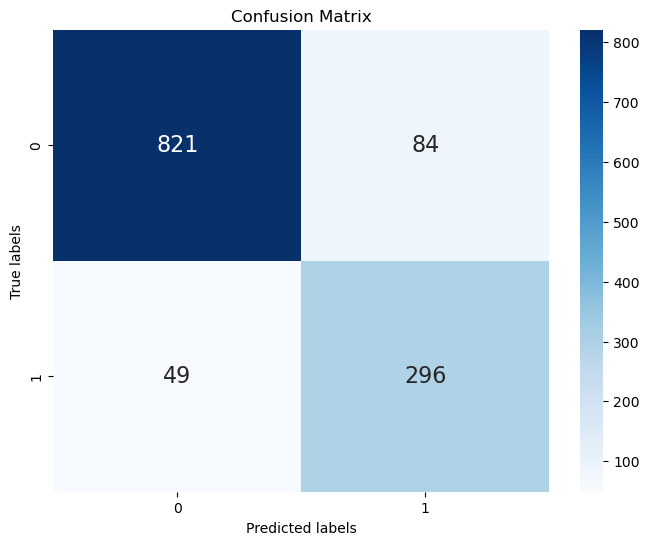

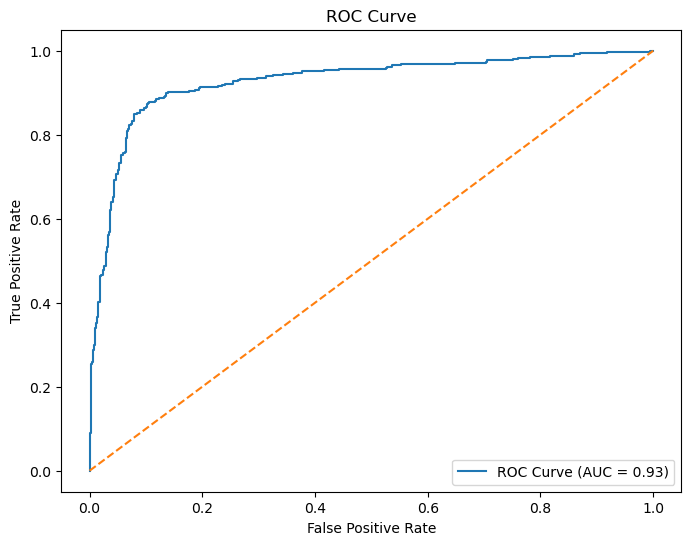

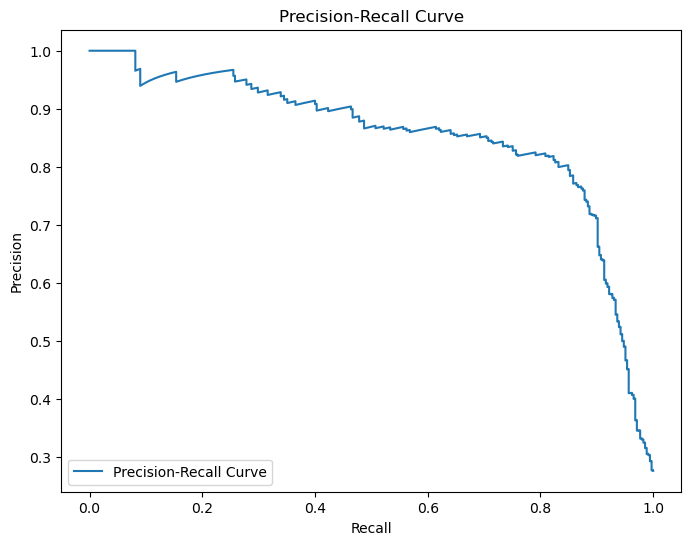

In [11]:
val_predictions = best_rf.predict(X_val)

accuracy = accuracy_score(y_val, val_predictions)
precision = precision_score(y_val, val_predictions)
recall = recall_score(y_val, val_predictions)
f1 = f1_score(y_val, val_predictions)
roc_auc = roc_auc_score(y_val, best_rf.predict_proba(X_val)[:, 1])

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

cm = confusion_matrix(y_val, val_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", annot_kws={"size": 16})
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

fpr, tpr, thresholds = roc_curve(y_val, best_rf.predict_proba(X_val)[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

precision, recall, thresholds = precision_recall_curve(y_val, best_rf.predict_proba(X_val)[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


In [16]:
subset_with_no_comments = np.all(X_val[:, -768:] == 0, axis=1)
X_val_subset = X_val[subset_with_no_comments]
y_val_subset = y_val[subset_with_no_comments]

print("X_val_subset shape:", X_val_subset.shape)
print("y_val_subset shape:", y_val_subset.shape)

val_subset_predictions = best_rf.predict(X_val_subset)

val_subset_f1_score = f1_score(y_val_subset, val_subset_predictions)

print("Validation F1 score for subset where last 768 values are 0: ", val_subset_f1_score)

X_val_subset shape: (417, 2304)
y_val_subset shape: (417,)
Validation F1 score for subset where last 768 values are 0:  0.8672566371681417


In [19]:

accuracy = accuracy_score(y_val_subset, val_subset_predictions)
precision = precision_score(y_val_subset, val_subset_predictions)
recall = recall_score(y_val_subset, val_subset_predictions)
f1 = f1_score(y_val_subset, val_subset_predictions)
roc_auc = roc_auc_score(y_val_subset, best_rf.predict_proba(X_val_subset)[:, 1])

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)


Accuracy: 0.7841726618705036
Precision: 0.7777777777777778
Recall: 0.98
F1 Score: 0.8672566371681417
ROC AUC Score: 0.7948433048433048


# 5 - PRODUCING TEST PREDICTIONS

In [12]:
df_test = pd.read_excel("/Users/diogoparreira/Downloads/Project Corpora/test.xlsx")

df_test_reviews = pd.read_excel("/Users/diogoparreira/Downloads/Project Corpora/test_reviews.xlsx")




In [13]:
def pivot_comments(df):
    df['comment_num'] = df.groupby('index').cumcount() + 1

    df_pivoted = df.pivot_table(index='index', columns='comment_num', values='comments', aggfunc='first')

    df_pivoted.columns = [f'comment {i}' for i in range(1, 11)]

    df_pivoted.reset_index(inplace=True)

    return df_pivoted

In [14]:
def ensure_ten_comments_per_index(df, max_index):
    result_df = pd.DataFrame(columns=df.columns)

    for idx in range(1, max_index + 1):
        comments = df[df['index'] == idx]

        if len(comments) < 10:
            missing_count = 10 - len(comments)
            empty_comments = pd.DataFrame({'index': [idx] * missing_count, 'comments': [''] * missing_count})
            comments = pd.concat([comments, empty_comments], ignore_index=True)

        result_df = pd.concat([result_df, comments], ignore_index=True)

    return result_df

In [21]:
# same preprocessing as the BERT EMBEDDINGS ABOVE 
df_test_reviews_10 = df_test_reviews.groupby('index').apply(lambda x: x.sample(n=min(len(x), 10), random_state=42)).reset_index(drop=True)
max_index_test = df_test_reviews["index"].max()
df_sampled_test = ensure_ten_comments_per_index(df_test_reviews_10, max_index_test)
df_pivoted_test = pivot_comments(df_sampled_test)
df_test = pd.merge(df_test, df_pivoted_test, on='index', how='left')
df_test = clean_dataframe(df_test)


In [ ]:
#EMBEDD THE TEST
descriptions = df_test['description'].astype(str).tolist()
description_embeddings = []

for desc in tqdm(descriptions, desc="Embedding descriptions"):
    description_embeddings.append(get_distilbert_embedding(desc))

df_test['description_embedding'] = description_embeddings

host_abouts = df_test['host_about'].astype(str).tolist()

host_about_embeddings = []
for host_about in tqdm(host_abouts, desc="Embedding host abouts"):
    host_about_embeddings.append(get_distilbert_embedding(host_about))

df_test['host_about_embedding'] = host_about_embeddings

comments_columns = ['comment 1', 'comment 2', 'comment 3', 'comment 4', 'comment 5', 
                    'comment 6', 'comment 7', 'comment 8', 'comment 9', 'comment 10']

comments_embeddings = {col: [] for col in comments_columns}

for col in comments_columns:
    comments = df_test[col].tolist()
    for comment in tqdm(comments, desc=f"Embedding {col}"):
        if isinstance(comment, str):
            comments_embeddings[col].append(get_distilbert_embedding(comment))
        else:
            comments_embeddings[col].append(np.zeros(768))

for col in comments_columns:
    df_test[f'{col}_embedding'] = comments_embeddings[col]

Embedding descriptions:   0%|          | 0/695 [00:00<?, ?it/s]

Embedding host abouts:   0%|          | 0/695 [00:00<?, ?it/s]

Embedding comment 1:   0%|          | 0/695 [00:00<?, ?it/s]

Embedding comment 2:   0%|          | 0/695 [00:00<?, ?it/s]

Embedding comment 3:   0%|          | 0/695 [00:00<?, ?it/s]

Embedding comment 4:   0%|          | 0/695 [00:00<?, ?it/s]

Embedding comment 5:   0%|          | 0/695 [00:00<?, ?it/s]

Embedding comment 6:   0%|          | 0/695 [00:00<?, ?it/s]

Embedding comment 7:   0%|          | 0/695 [00:00<?, ?it/s]

Embedding comment 8:   0%|          | 0/695 [00:00<?, ?it/s]

Embedding comment 9:   0%|          | 0/695 [00:00<?, ?it/s]

Embedding comment 10:   0%|          | 0/695 [00:00<?, ?it/s]

In [ ]:
X_train = full_training.copy()
y_train = full_target.copy()

In [ ]:

best_rf.fit(X_train, y_train)

X_test = df_test[['description_embedding', 'host_about_embedding', 
                  'comment 1_embedding', 'comment 2_embedding', 'comment 3_embedding', 
                  'comment 4_embedding', 'comment 5_embedding', 'comment 6_embedding', 
                  'comment 7_embedding', 'comment 8_embedding', 'comment 9_embedding', 
                  'comment 10_embedding']]




In [ ]:
X_test_flattened = X_test.apply(flatten_row, axis=1)
X_test = np.vstack(X_test_flattened.values)

def average_and_reduce(row, num_features=12, embedding_size=768, num_comments=10):

    embeddings = row.reshape((num_features, embedding_size))

    averaged_comments = np.mean(embeddings[-num_comments:], axis=0)

    reduced_embeddings = np.concatenate([embeddings[0], embeddings[1], averaged_comments])
    return reduced_embeddings

X_test = np.apply_along_axis(average_and_reduce, 1, X_test)

test_predictions = best_rf.predict(X_test)

output_file_path = "/Users/diogoparreira/Downloads/Project Corpora/test_predictions.csv"

In [ ]:
test_predictions

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0.,
       1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1.,
       0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0.

In [ ]:
test_predictions = pd.DataFrame(test_predictions, columns=['unlisted'])
test_predictions['unlisted'].value_counts()




0.0    492
1.0    203
Name: unlisted, dtype: int64

In [ ]:
# It's what I was expecting 